# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></div><div class="lev1 toc-item"><a href="#Exploration-des-notes" data-toc-modified-id="Exploration-des-notes-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploration des notes</a></div><div class="lev2 toc-item"><a href="#Ratings" data-toc-modified-id="Ratings-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Ratings</a></div><div class="lev2 toc-item"><a href="#General-Infos" data-toc-modified-id="General-Infos-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>General Infos</a></div><div class="lev2 toc-item"><a href="#Cast-du-film" data-toc-modified-id="Cast-du-film-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Cast du film</a></div><div class="lev2 toc-item"><a href="#Jointure-&lt;casting,-movie&gt;" data-toc-modified-id="Jointure-<casting,-movie>-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Jointure &lt;casting, movie&gt;</a></div><div class="lev1 toc-item"><a href="#Ajout-des-données-scrapées" data-toc-modified-id="Ajout-des-données-scrapées-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Ajout des données scrapées</a></div>

# Imports

In [2]:
import json
import os
import sys
import time
import random
import datetime
from collections import *
import re

from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_pandas
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import *

%matplotlib inline

In [139]:
tqdm.pandas(desc="progress bar")
pd.set_option("display.max_columns", 100)

In [4]:
sns_palette = sns.color_palette("Blues", n_colors=1)

In [7]:
os.listdir("../data/")

['name.basics.tsv.gz',
 'IMDB_SYNOPSIS_20180209.json.zip',
 'title.basics.tsv.gz',
 'movies_with_cast_data_20171104.csv',
 'title.principals.tsv.gz',
 'title.ratings.tsv.gz',
 'IMDB_SYNOPSIS_20180209.json']

# Exploration des notes

## Ratings

In [8]:
df_rating = pd.read_csv("../data/title.ratings.tsv.gz", sep="\t")

In [14]:
df_rating.head()

tconst  averageRating  numVotes
0  tt0000001            5.8      1421
1  tt0000002            6.4       168
2  tt0000003            6.6      1015
3  tt0000004            6.4       100
4  tt0000005            6.2      1713

In [10]:
df_rating.shape

(873723, 3)

In [11]:
df_rating.describe()

averageRating      numVotes
count  873723.000000  8.737230e+05
mean        6.928187  9.740114e+02
std         1.397808  1.540431e+04
min         1.000000  5.000000e+00
25%         6.200000  9.000000e+00
50%         7.100000  2.000000e+01
75%         7.900000  7.700000e+01
max        10.000000  2.003111e+06

In [12]:
df_rating["averageRating"] = df_rating["averageRating"].apply(lambda x: round(x, 2))

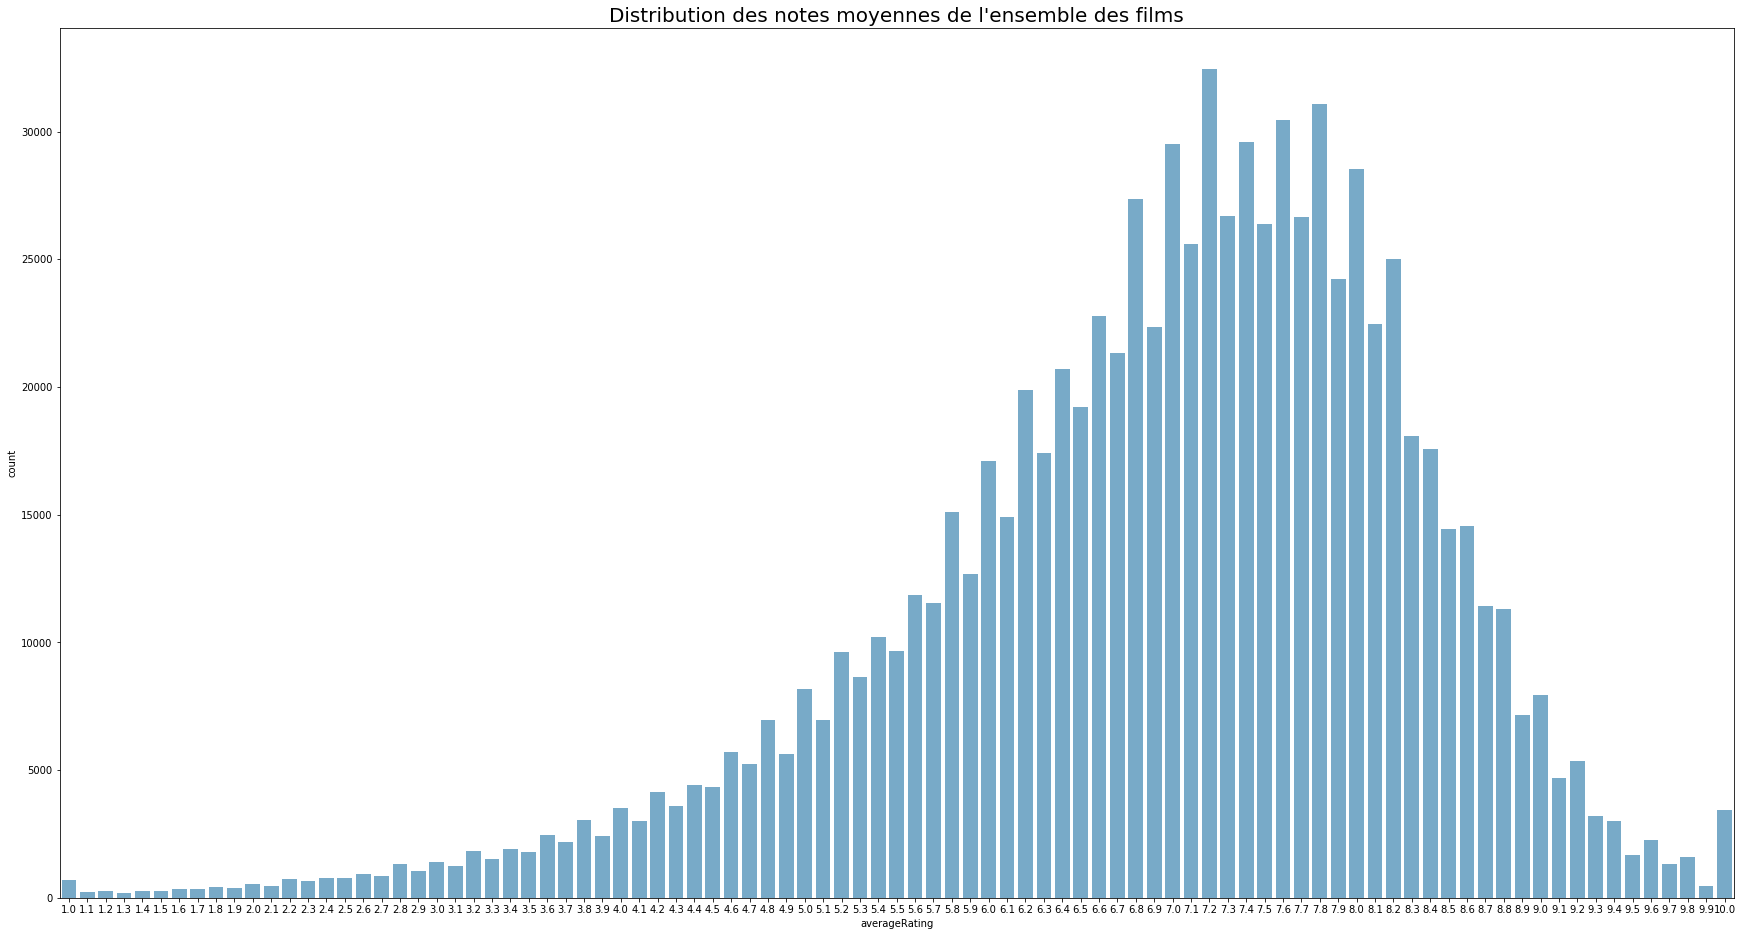

In [16]:
plt.figure(figsize=(30, 16))
sns.countplot(df_rating["averageRating"], palette=sns_palette)
plt.title("Distribution des notes moyennes de l'ensemble des films", {"fontsize": 20});

<Figure size 1152x576 with 0 Axes>

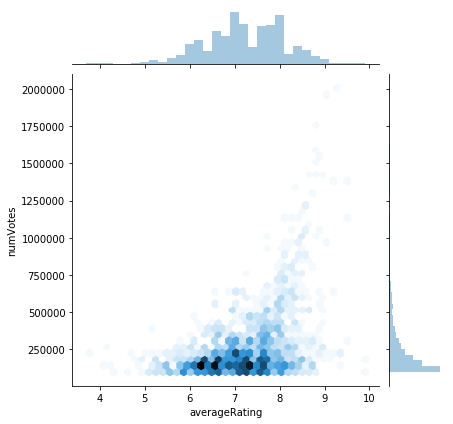

In [17]:
plt.figure(figsize=(16, 8))
ax = sns.jointplot(x="averageRating", y="numVotes", data=df_rating[df_rating["numVotes"] > 100000], kind="hex");

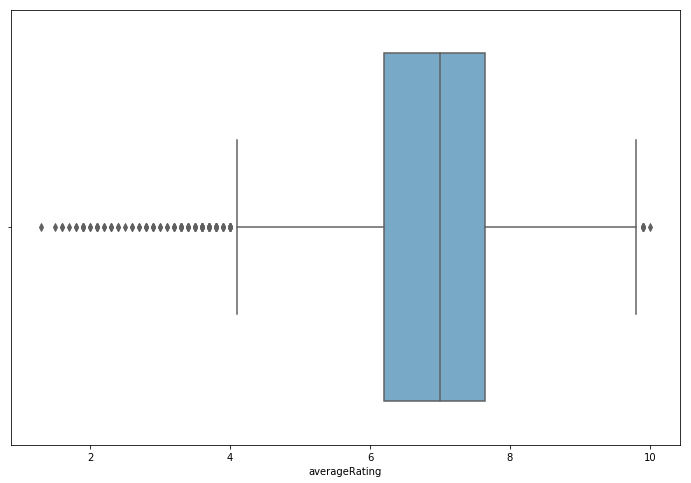

In [18]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="averageRating", data=df_rating[df_rating["numVotes"] > 10000], palette=sns_palette);

## General Infos

In [19]:
df_data = pd.read_csv("../data/title.basics.tsv.gz", sep="\t")

/home/clement/dev/miniconda3/envs/movie-success-prediction/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
df_data.head()

tconst titleType            primaryTitle           originalTitle  \
0  tt0000001     short              Carmencita              Carmencita   
1  tt0000002     short  Le clown et ses chiens  Le clown et ses chiens   
2  tt0000003     short          Pauvre Pierrot          Pauvre Pierrot   
3  tt0000004     short             Un bon bock             Un bon bock   
4  tt0000005     short        Blacksmith Scene        Blacksmith Scene   

   isAdult startYear endYear runtimeMinutes                    genres  
0        0      1894      \N              1         Documentary,Short  
1        0      1892      \N              5           Animation,Short  
2        0      1892      \N              4  Animation,Comedy,Romance  
3        0      1892      \N             \N           Animation,Short  
4        0      1893      \N              1              Comedy,Short

In [22]:
df_data.replace("\\N", np.nan, inplace=True)

In [23]:
df_data.shape

(5325001, 9)

In [24]:
df_data_rating = df_data.merge(df_rating, left_on="tconst", right_on="tconst", how="inner")

In [25]:
df_data_rating.head()

tconst titleType            primaryTitle           originalTitle  \
0  tt0000001     short              Carmencita              Carmencita   
1  tt0000002     short  Le clown et ses chiens  Le clown et ses chiens   
2  tt0000003     short          Pauvre Pierrot          Pauvre Pierrot   
3  tt0000004     short             Un bon bock             Un bon bock   
4  tt0000005     short        Blacksmith Scene        Blacksmith Scene   

   isAdult startYear endYear runtimeMinutes                    genres  \
0        0      1894     NaN              1         Documentary,Short   
1        0      1892     NaN              5           Animation,Short   
2        0      1892     NaN              4  Animation,Comedy,Romance   
3        0      1892     NaN            NaN           Animation,Short   
4        0      1893     NaN              1              Comedy,Short   

   averageRating  numVotes  
0            5.8      1421  
1            6.4       168  
2            6.6      1015  
3            6.4       100  
4            6.2      1713

In [26]:
df_data_rating.shape

(873723, 11)

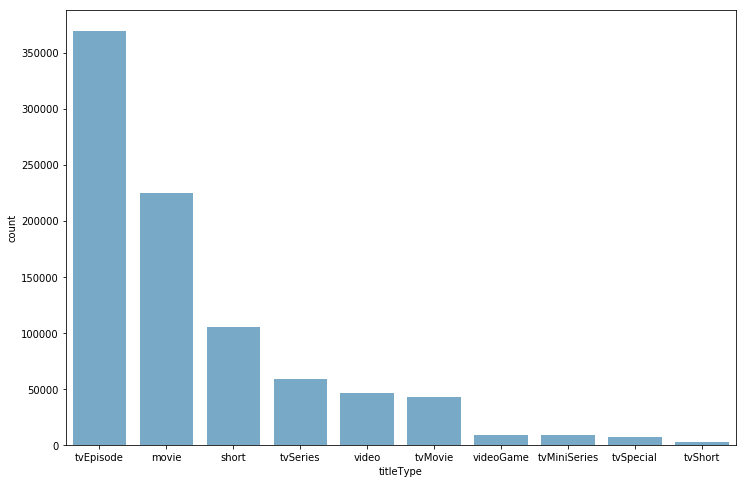

In [27]:
plt.figure(figsize=(12, 8))
sns.countplot(x="titleType", data=df_data_rating, palette=sns_palette, order=df_data_rating.titleType.value_counts().index);

__tvX__ : produit pour la télévision
<br> sinon, produit initialement pour le cinéma </br>
<br> source : http://www.imdb.com/help/show_leaf?titletypes </br>

__Movie__ : film produit pour le cinéma
<br> Short : court-métrages </br>
<br> ==> on ne s'intéresse qu'aux films dont le type est _Movie_  </br>

In [28]:
df_movies = df_data_rating[df_data_rating["titleType"] == "movie"]

In [29]:
movies_set = set(df_movies["tconst"].tolist())

In [30]:
df_movies.shape

(224497, 11)

In [31]:
df_movies["endYear"].value_counts()

2010    1
Name: endYear, dtype: int64

cette colonne n'a aucune donnée
<br> ==> on peut la supprimer </br>

In [32]:
df_movies.rename(columns={"startYear": "productionYear"}, inplace=True) 
del df_movies["endYear"]

/home/clement/dev/miniconda3/envs/movie-success-prediction/lib/python3.6/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [33]:
df_movies.head()

tconst titleType                   primaryTitle  \
8    tt0000009     movie                     Miss Jerry   
143  tt0000147     movie  The Corbett-Fitzsimmons Fight   
236  tt0000335     movie          Soldiers of the Cross   
340  tt0000574     movie    The Story of the Kelly Gang   
356  tt0000615     movie             Robbery Under Arms   

                     originalTitle  isAdult productionYear runtimeMinutes  \
8                       Miss Jerry        0           1894             45   
143  The Corbett-Fitzsimmons Fight        0           1897             20   
236          Soldiers of the Cross        0           1900            NaN   
340    The Story of the Kelly Gang        0           1906             70   
356             Robbery Under Arms        0           1907            NaN   

                     genres  averageRating  numVotes  
8                   Romance            5.5        69  
143  Documentary,News,Sport            5.2       266  
236         Biography,Drama            6.2        35  
340   Biography,Crime,Drama            6.3       474  
356                   Drama            5.1        13

In [34]:
df_movies = df_movies.reset_index()

In [35]:
def transform_genres(row):
    # Séparation des différents genres en colonne
    
    if pd.notnull(row["genres"]):
        genres = row["genres"].split(",")
        for genre in genres:            
            row["is_%s" % genre.lower()] = 1

    return row

In [37]:
df_movies = df_movies.progress_apply(lambda row: transform_genres(row), axis=1)

progress bar: 100%|██████████| 224497/224497 [04:44<00:00, 789.26it/s] 


In [38]:
today = datetime.datetime.today()
def add_age_metadata(x):
    if pd.notnull(x):
        return today.year - int(x)
    

In [39]:
df_movies["age"] = df_movies["productionYear"].apply(lambda x: add_age_metadata(x))

In [40]:
df_movies["runtimeMinutes"] = df_movies["runtimeMinutes"].astype(float)

In [41]:
df_movies.head()

averageRating                  genres  index  isAdult  is_action  is_adult  \
0            5.5                 Romance      8        0        NaN       NaN   
1            5.2  Documentary,News,Sport    143        0        NaN       NaN   
2            6.2         Biography,Drama    236        0        NaN       NaN   
3            6.3   Biography,Crime,Drama    340        0        NaN       NaN   
4            5.1                   Drama    356        0        NaN       NaN   

   is_adventure  is_animation  is_biography  is_comedy  is_crime  \
0           NaN           NaN           NaN        NaN       NaN   
1           NaN           NaN           NaN        NaN       NaN   
2           NaN           NaN           1.0        NaN       NaN   
3           NaN           NaN           1.0        NaN       1.0   
4           NaN           NaN           NaN        NaN       NaN   

   is_documentary  is_drama  is_family  is_fantasy  is_film-noir  \
0             NaN       NaN        NaN         NaN           NaN   
1             1.0       NaN        NaN         NaN           NaN   
2             NaN       1.0        NaN         NaN           NaN   
3             NaN       1.0        NaN         NaN           NaN   
4             NaN       1.0        NaN         NaN           NaN   

   is_game-show  is_history  is_horror  is_music  is_musical  is_mystery  \
0           NaN         NaN        NaN       NaN         NaN         NaN   
1           NaN         NaN        NaN       NaN         NaN         NaN   
2           NaN         NaN        NaN       NaN         NaN         NaN   
3           NaN         NaN        NaN       NaN         NaN         NaN   
4           NaN         NaN        NaN       NaN         NaN         NaN   

   is_news  is_reality-tv  is_romance  is_sci-fi  is_short  is_sport  \
0      NaN            NaN         1.0        NaN       NaN       NaN   
1      1.0            NaN         NaN        NaN       NaN       1.0   
2      NaN            NaN         NaN        NaN       NaN       NaN   
3      NaN            NaN         NaN        NaN       NaN       NaN   
4      NaN            NaN         NaN        NaN       NaN       NaN   

   is_talk-show  is_thriller  is_war  is_western  numVotes  \
0           NaN          NaN     NaN         NaN        69   
1           NaN          NaN     NaN         NaN       266   
2           NaN          NaN     NaN         NaN        35   
3           NaN          NaN     NaN         NaN       474   
4           NaN          NaN     NaN         NaN        13   

                   originalTitle                   primaryTitle  \
0                     Miss Jerry                     Miss Jerry   
1  The Corbett-Fitzsimmons Fight  The Corbett-Fitzsimmons Fight   
2          Soldiers of the Cross          Soldiers of the Cross   
3    The Story of the Kelly Gang    The Story of the Kelly Gang   
4             Robbery Under Arms             Robbery Under Arms   

  productionYear  runtimeMinutes     tconst titleType    age  
0           1894            45.0  tt0000009     movie  124.0  
1           1897            20.0  tt0000147     movie  121.0  
2           1900             NaN  tt0000335     movie  118.0  
3           1906            70.0  tt0000574     movie  112.0  
4           1907             NaN  tt0000615     movie  111.0

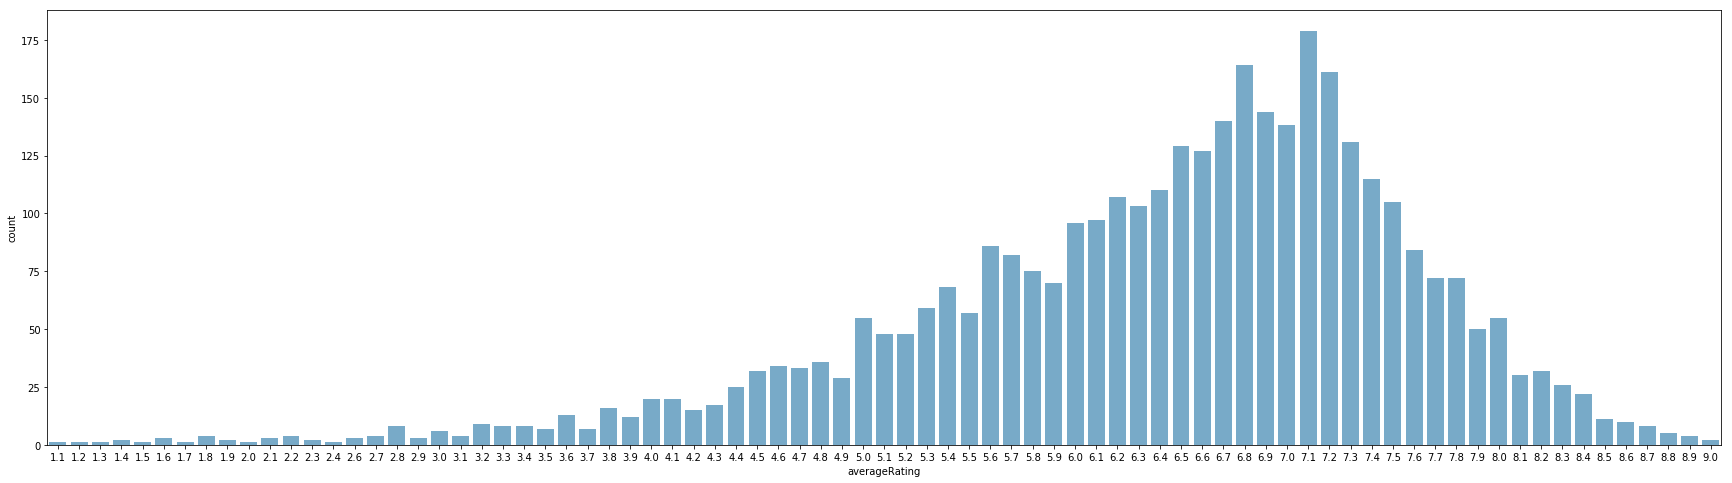

In [43]:
plt.figure(figsize=(30, 8))
sns.countplot("averageRating", data=df_movies[df_movies["is_animation"] == 1], palette=sns_palette)

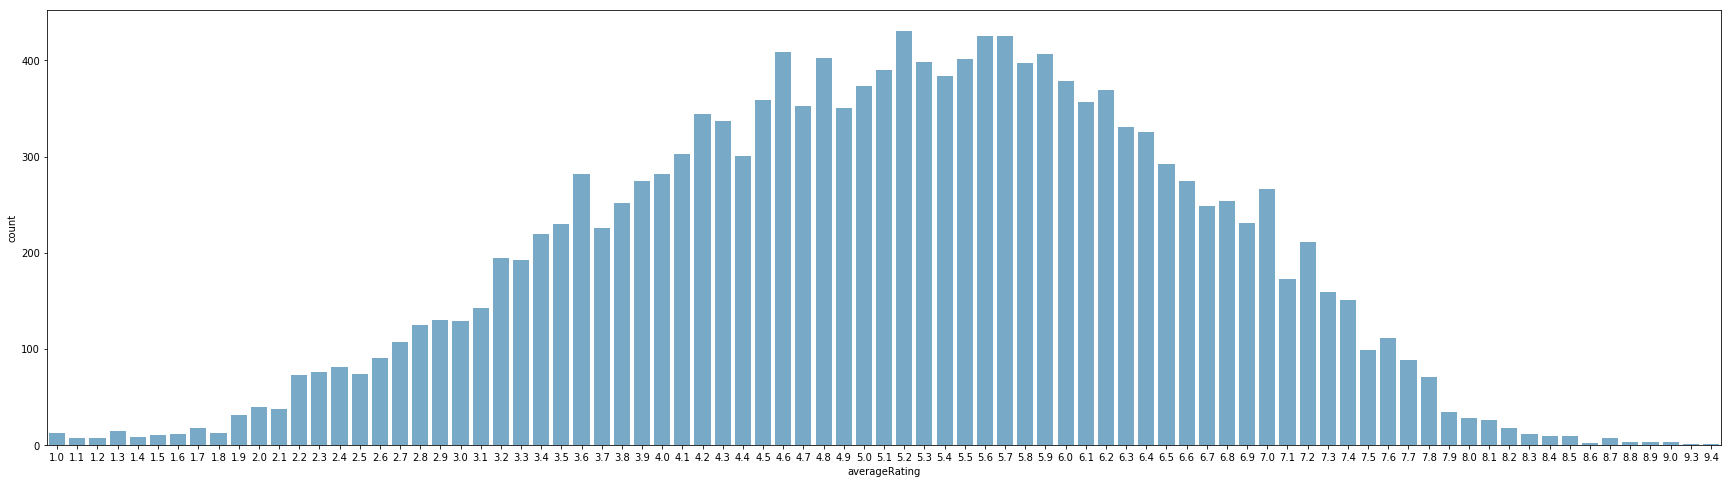

In [44]:
plt.figure(figsize=(30, 8))
sns.countplot("averageRating", data=df_movies[df_movies["is_horror"] == 1], palette=sns_palette)

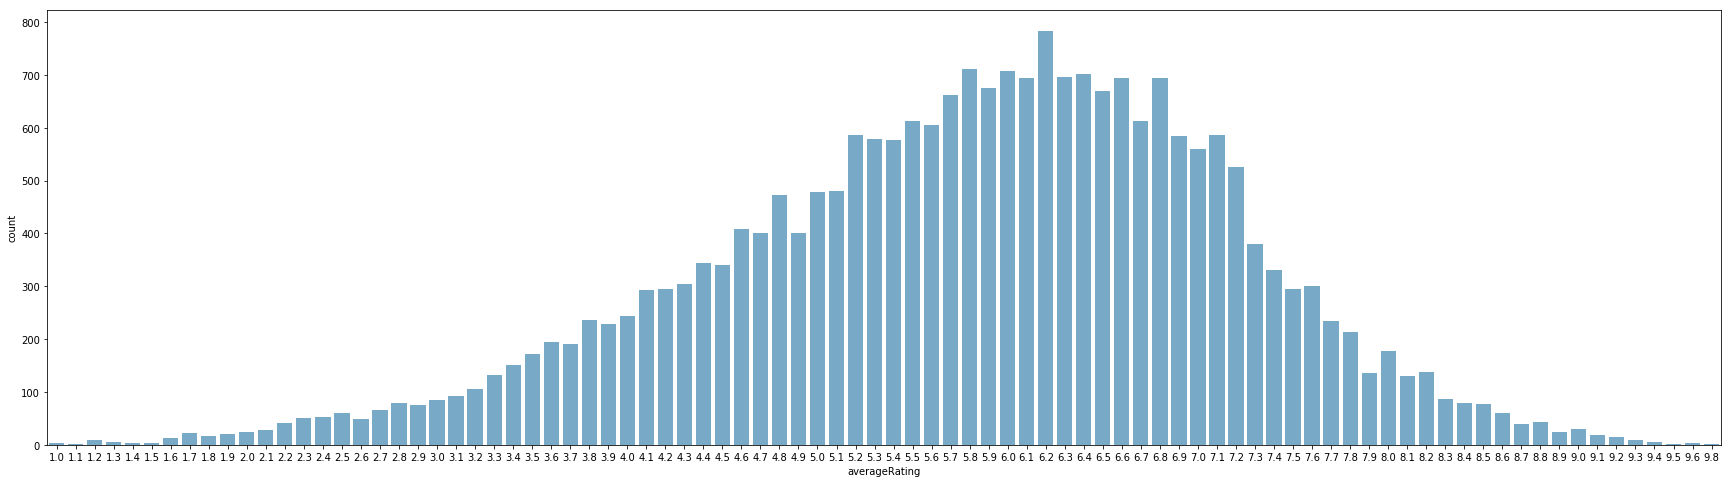

In [45]:
plt.figure(figsize=(30, 8))
sns.countplot("averageRating", data=df_movies[df_movies["is_action"] == 1], palette=sns_palette)

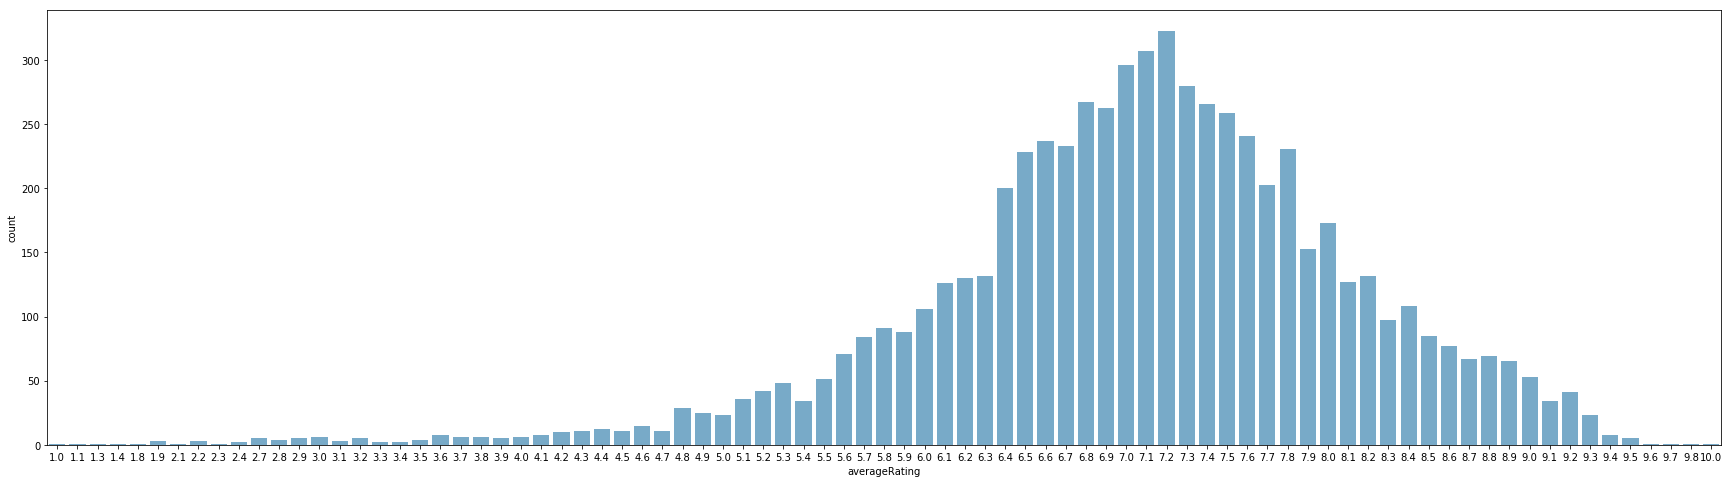

In [46]:
plt.figure(figsize=(30, 8))
sns.countplot("averageRating", data=df_movies[df_movies["is_biography"] == 1], palette=sns_palette)

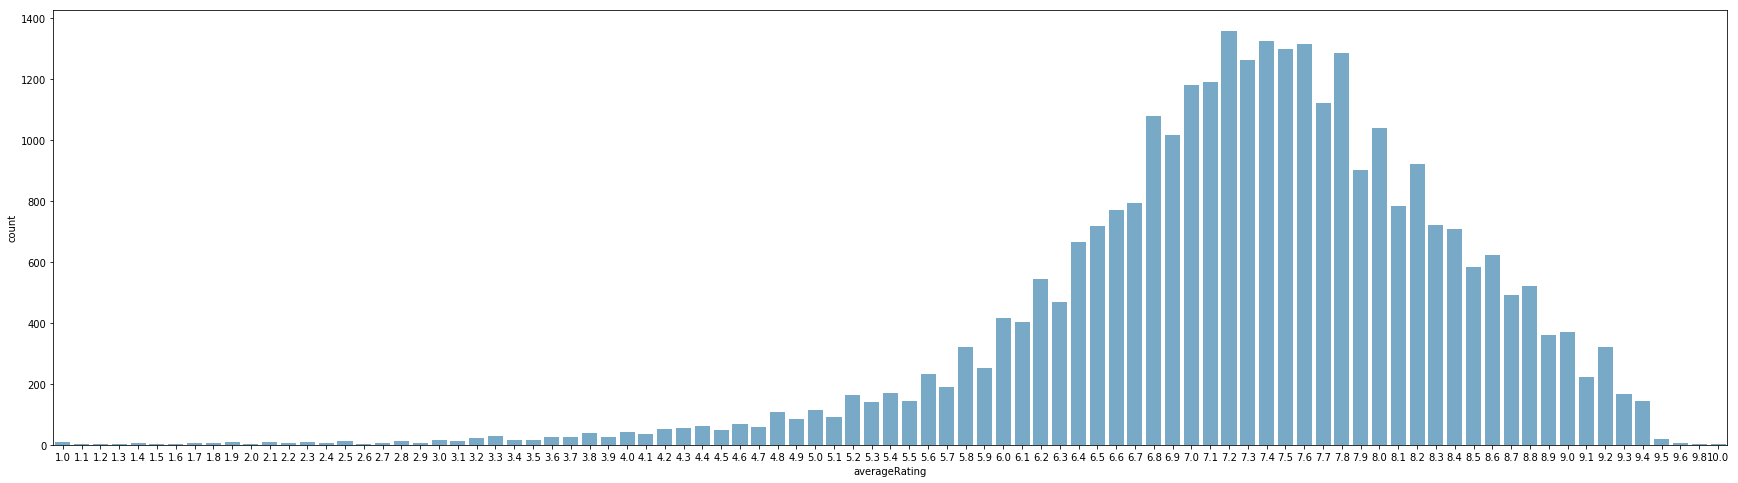

In [47]:
plt.figure(figsize=(30, 8))
sns.countplot("averageRating", data=df_movies[df_movies["is_documentary"] == 1], palette=sns_palette)

## Cast du film

In [48]:
df_principals = pd.read_csv("../data/title.principals.tsv.gz", sep="\t")

In [52]:
df_principals.head()

tconst  ordering     nconst         category                      job  \
0  tt0000001         1  nm1588970             self                       \N   
1  tt0000001         2  nm0005690         director                       \N   
2  tt0000001         3  nm0374658  cinematographer  director of photography   
3  tt0000002         1  nm0721526         director                       \N   
4  tt0000002         2  nm1335271         composer                       \N   

    characters  
0  ["Herself"]  
1           \N  
2           \N  
3           \N  
4           \N

In [53]:
df_principals_movies = df_principals[df_principals["tconst"].isin(movies_set)]
df_principals_movies = df_principals_movies.reset_index()

KeyboardInterrupt: 

In [54]:
df_principals.shape

(30281076, 6)

In [55]:
df_principals.tconst.unique().shape

(4762546,)

In [58]:
tconst_filter = set(df_principals["tconst"].unique()).intersection(movies_set)
len(tconst_filter)

224112

In [63]:
df_principals["to_keep"] = df_principals["tconst"].progress_apply(lambda x: x in tconst_filter)


progress bar:  56%|█████▌    | 16924972/30281076 [00:20<00:15, 854996.77it/s]


progress bar: 100%|██████████| 30281076/30281076 [00:37<00:00, 810479.52it/s]

In [64]:
df_principals_movies = df_principals[df_principals["to_keep"] == True]
df_principals_movies = df_principals_movies.reset_index()

In [65]:
df_principals_movies.shape

(2009046, 8)

In [66]:
df_principals_movies.drop("to_keep", axis=1, inplace=True)

In [67]:
df_name = pd.read_csv("../data/name.basics.tsv.gz", sep="\t")

In [68]:
df_name.head()

nconst      primaryName birthYear deathYear  \
0  nm0000001     Fred Astaire      1899      1987   
1  nm0000002    Lauren Bacall      1924      2014   
2  nm0000003  Brigitte Bardot      1934        \N   
3  nm0000004     John Belushi      1949      1982   
4  nm0000005   Ingmar Bergman      1918      2007   

                primaryProfession                           knownForTitles  
0  soundtrack,actor,miscellaneous  tt0053137,tt0072308,tt0043044,tt0050419  
1              actress,soundtrack  tt0037382,tt0071877,tt0038355,tt0117057  
2     actress,soundtrack,producer  tt0049189,tt0054452,tt0059956,tt0057345  
3         actor,writer,soundtrack  tt0078723,tt0080455,tt0072562,tt0077975  
4           writer,director,actor  tt0050976,tt0083922,tt0060827,tt0050986

In [69]:
df_name.shape

(8896233, 6)

In [70]:
df_name.replace("\\N", np.nan, inplace=True)

In [75]:
df_name["knownForTitles"].isnull().value_counts()

False    7792593
True     1103640
Name: knownForTitles, dtype: int64

In [76]:
df_name = df_name[pd.notnull(df_name["knownForTitles"])]

In [77]:
df_name.shape

(7792593, 6)

In [78]:
df_name["nb_titles_known_for"] = df_name["knownForTitles"].apply(lambda x: x.count(",") + 1)

In [79]:
df_professions = pd.DataFrame([item for items in df_name[pd.notnull(df_name["primaryProfession"])].sample(1000)["primaryProfession"].tolist() for item in items.split(",")])

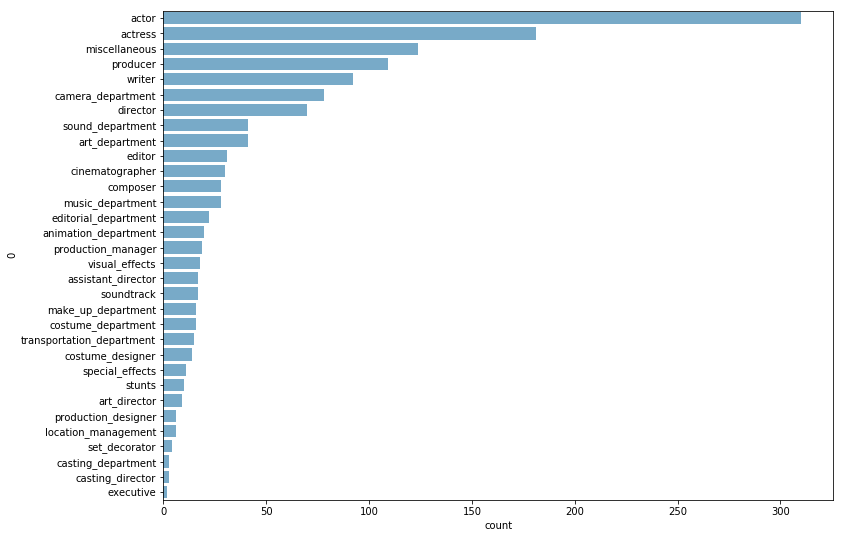

In [80]:
plt.figure(figsize=(12, 9))
sns.countplot(y=df_professions[0], palette=sns_palette, order=df_professions[0].value_counts().index)

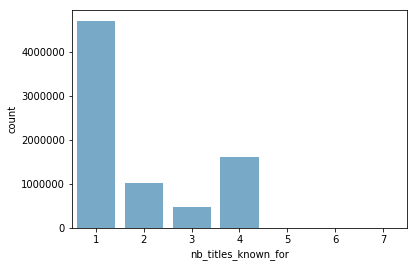

In [81]:
sns.countplot(df_name["nb_titles_known_for"], palette=sns_palette)

==> Il semble ici qu'on a pas l'intégralité de la filmogrpahie des acteurs/réalisateurs.

In [83]:
def transform_cast(row):
    casting = row["principalCast"].split(",")
    row["casting_crew"] = len(casting)
    row["casting"] = casting
    return row

In [87]:
!ls ../data

IMDB_SYNOPSIS_20180209.json	    title.basics.tsv.gz
IMDB_SYNOPSIS_20180209.json.zip     title.principals.tsv.gz
movies_with_cast_data_20171104.csv  title.ratings.tsv.gz
name.basics.tsv.gz


In [85]:
df_principals_movies.head()

index     tconst  ordering     nconst  category job  \
0     24  tt0000009         1  nm0063086   actress  \N   
1     25  tt0000009         2  nm0183823     actor  \N   
2     26  tt0000009         3  nm1309758      self  \N   
3     27  tt0000009         4  nm0085156  director  \N   
4    252  tt0000147         1  nm0179163      self  \N   

                                          characters  
0           ["Miss Geraldine Holbrook (Miss Jerry)"]  
1                                   ["Mr. Hamilton"]  
2  ["Himself - the Director of the New York Centr...  
3                                                 \N  
4                                        ["Himself"]

In [134]:
df_casting = df_principals_movies.groupby("tconst", as_index=False).agg({
    "nconst": {
        "casting_crew": "size",
        "principalCast": lambda x: ",".join(sorted(x.tolist())),
        "casting": lambda x: sorted(x)}
})

In [135]:
df_casting.head()

tconst       nconst                                                     \
             casting_crew                                      principalCast   
0  tt0000009            4            nm0063086,nm0085156,nm0183823,nm1309758   
1  tt0000147            7  nm0103755,nm0179163,nm0280615,nm0714557,nm2256...   
2  tt0000335            8  nm0095714,nm0675140,nm0675239,nm0675260,nm1010...   
3  tt0000574           10  nm0170118,nm0317210,nm0425854,nm0675239,nm0846...   
4  tt0000615            9  nm0092809,nm0167619,nm0218953,nm0240418,nm0346...   

                                                      
                                             casting  
0       [nm0063086, nm0085156, nm0183823, nm1309758]  
1  [nm0103755, nm0179163, nm0280615, nm0714557, n...  
2  [nm0095714, nm0675140, nm0675239, nm0675260, n...  
3  [nm0170118, nm0317210, nm0425854, nm0675239, n...  
4  [nm0092809, nm0167619, nm0218953, nm0240418, n...

In [136]:
df_casting.columns = [list(df_casting.columns.get_level_values(0))[0]] + list(df_casting.columns.get_level_values(1))[1:]

In [137]:
df_casting.head()

tconst  casting_crew                                      principalCast  \
0  tt0000009             4            nm0063086,nm0085156,nm0183823,nm1309758   
1  tt0000147             7  nm0103755,nm0179163,nm0280615,nm0714557,nm2256...   
2  tt0000335             8  nm0095714,nm0675140,nm0675239,nm0675260,nm1010...   
3  tt0000574            10  nm0170118,nm0317210,nm0425854,nm0675239,nm0846...   
4  tt0000615             9  nm0092809,nm0167619,nm0218953,nm0240418,nm0346...   

                                             casting  
0       [nm0063086, nm0085156, nm0183823, nm1309758]  
1  [nm0103755, nm0179163, nm0280615, nm0714557, n...  
2  [nm0095714, nm0675140, nm0675239, nm0675260, n...  
3  [nm0170118, nm0317210, nm0425854, nm0675239, n...  
4  [nm0092809, nm0167619, nm0218953, nm0240418, n...

In [140]:
cast_data = {v["nconst"]: v for v in tqdm(df_name.to_dict(orient="index").values()) if set(v["knownForTitles"].split(",")).intersection(movies_set) }

KeyboardInterrupt: 

In [141]:
df_name.head()

nconst      primaryName birthYear deathYear  \
0  nm0000001     Fred Astaire      1899      1987   
1  nm0000002    Lauren Bacall      1924      2014   
2  nm0000003  Brigitte Bardot      1934       NaN   
3  nm0000004     John Belushi      1949      1982   
4  nm0000005   Ingmar Bergman      1918      2007   

                primaryProfession                           knownForTitles  \
0  soundtrack,actor,miscellaneous  tt0053137,tt0072308,tt0043044,tt0050419   
1              actress,soundtrack  tt0037382,tt0071877,tt0038355,tt0117057   
2     actress,soundtrack,producer  tt0049189,tt0054452,tt0059956,tt0057345   
3         actor,writer,soundtrack  tt0078723,tt0080455,tt0072562,tt0077975   
4           writer,director,actor  tt0050976,tt0083922,tt0060827,tt0050986   

   nb_titles_known_for  
0                    4  
1                    4  
2                    4  
3                    4  
4                    4

In [143]:
df_name.shape

(7792593, 7)

In [149]:
df_name["to_keep"] = df_name["knownForTitles"].progress_apply(lambda x: len(set(x.split(",")).intersection(movies_set)) > 0)



progress bar:   0%|          | 0/7792593 [00:00<?, ?it/s]

progress bar:   0%|          | 1201/7792593 [00:00<10:48, 12009.50it/s]

progress bar:   0%|          | 20857/7792593 [00:00<07:44, 16718.61it/s]

progress bar:   1%|          | 41374/7792593 [00:00<05:35, 23077.79it/s]

progress bar:   1%|          | 66189/7792593 [00:00<04:03, 31704.58it/s]

progress bar:   1%|          | 91428/7792593 [00:00<02:59, 42978.37it/s]

progress bar:   2%|▏         | 117327/7792593 [00:00<02:13, 57320.99it/s]

progress bar:   2%|▏         | 143617/7792593 [00:00<01:42, 74889.06it/s]

progress bar:   2%|▏         | 170574/7792593 [00:00<01:19, 95601.55it/s]

progress bar:   3%|▎         | 197664/7792593 [00:00<01:04, 118630.71it/s]

progress bar:   3%|▎         | 222384/7792593 [00:01<00:53, 140562.50it/s]

progress bar:   3%|▎         | 255890/7792593 [00:01<00:44, 170202.13it/s]

progress bar:   4%|▎         | 290068/7792593 [00:01<00:37, 200379.25it/s]

progress bar:   4%|▍         | 324874/779

progress bar:  43%|████▎     | 3348023/7792593 [00:10<00:13, 337495.32it/s]

progress bar:  43%|████▎     | 3386346/7792593 [00:10<00:12, 350026.40it/s]

progress bar:  44%|████▍     | 3425199/7792593 [00:10<00:12, 360750.76it/s]

progress bar:  44%|████▍     | 3463826/7792593 [00:10<00:11, 368043.92it/s]

progress bar:  45%|████▍     | 3502630/7792593 [00:10<00:11, 373819.97it/s]

progress bar:  45%|████▌     | 3541958/7792593 [00:10<00:11, 379449.42it/s]

progress bar:  46%|████▌     | 3580454/7792593 [00:10<00:11, 381083.37it/s]

progress bar:  46%|████▋     | 3619254/7792593 [00:10<00:10, 383132.16it/s]

progress bar:  47%|████▋     | 3657664/7792593 [00:11<00:10, 382645.66it/s]

progress bar:  47%|████▋     | 3696671/7792593 [00:11<00:10, 384841.32it/s]

progress bar:  48%|████▊     | 3735532/7792593 [00:11<00:10, 385960.77it/s]

progress bar:  48%|████▊     | 3774452/7792593 [00:11<00:10, 386926.15it/s]

progress bar:  49%|████▉     | 3813424/7792593 [00:11<00:10, 387759.92it/s]


progress bar:  93%|█████████▎| 7211888/7792593 [00:20<00:01, 342225.99it/s]

progress bar:  93%|█████████▎| 7253608/7792593 [00:20<00:01, 361726.29it/s]

progress bar:  94%|█████████▎| 7294967/7792593 [00:20<00:01, 375865.12it/s]

progress bar:  94%|█████████▍| 7336271/7792593 [00:20<00:01, 386295.30it/s]

progress bar:  95%|█████████▍| 7378310/7792593 [00:20<00:01, 395927.05it/s]

progress bar:  95%|█████████▌| 7419732/7792593 [00:20<00:00, 401240.34it/s]

progress bar:  96%|█████████▌| 7460102/7792593 [00:20<00:00, 360517.15it/s]

progress bar:  96%|█████████▌| 7500214/7792593 [00:20<00:00, 371805.27it/s]

progress bar:  97%|█████████▋| 7541470/7792593 [00:20<00:00, 383158.48it/s]

progress bar:  97%|█████████▋| 7581156/7792593 [00:21<00:00, 387165.69it/s]

progress bar:  98%|█████████▊| 7622859/7792593 [00:21<00:00, 395665.31it/s]

progress bar:  98%|█████████▊| 7662781/7792593 [00:21<00:00, 395108.67it/s]

progress bar:  99%|█████████▉| 7704097/7792593 [00:21<00:00, 400354.41it/s]


In [150]:
df_name.shape, df_name[df_name["to_keep"] == True].shape

((7792593, 8), (3213702, 8))

In [151]:
df_name = df_name[df_name["to_keep"] == True]

In [158]:
df_name.drop("to_keep", axis=1, inplace=True)

In [159]:
df_name.head()

nconst      primaryName birthYear deathYear  \
0  nm0000001     Fred Astaire      1899      1987   
1  nm0000002    Lauren Bacall      1924      2014   
2  nm0000003  Brigitte Bardot      1934       NaN   
3  nm0000004     John Belushi      1949      1982   
4  nm0000005   Ingmar Bergman      1918      2007   

                primaryProfession                           knownForTitles  \
0  soundtrack,actor,miscellaneous  tt0053137,tt0072308,tt0043044,tt0050419   
1              actress,soundtrack  tt0037382,tt0071877,tt0038355,tt0117057   
2     actress,soundtrack,producer  tt0049189,tt0054452,tt0059956,tt0057345   
3         actor,writer,soundtrack  tt0078723,tt0080455,tt0072562,tt0077975   
4           writer,director,actor  tt0050976,tt0083922,tt0060827,tt0050986   

   nb_titles_known_for  
0                    4  
1                    4  
2                    4  
3                    4  
4                    4

In [160]:
df_name.to_csv("../data/cast_data.csv", encoding="utf-8", index=False)

In [184]:
df_name.set_index("nconst").to_json("../data/cast_data.json", orient="index")

In [185]:
with open("../data/cast_data.json") as f:
    cast_data = json.load(f)

In [186]:
len(cast_data)

3213702

## Jointure <casting, movie>

In [161]:
df_movies.head()

averageRating                  genres  index  isAdult  is_action  is_adult  \
0            5.5                 Romance      8        0        NaN       NaN   
1            5.2  Documentary,News,Sport    143        0        NaN       NaN   
2            6.2         Biography,Drama    236        0        NaN       NaN   
3            6.3   Biography,Crime,Drama    340        0        NaN       NaN   
4            5.1                   Drama    356        0        NaN       NaN   

   is_adventure  is_animation  is_biography  is_comedy  is_crime  \
0           NaN           NaN           NaN        NaN       NaN   
1           NaN           NaN           NaN        NaN       NaN   
2           NaN           NaN           1.0        NaN       NaN   
3           NaN           NaN           1.0        NaN       1.0   
4           NaN           NaN           NaN        NaN       NaN   

   is_documentary  is_drama  is_family  is_fantasy  is_film-noir  \
0             NaN       NaN        NaN         NaN           NaN   
1             1.0       NaN        NaN         NaN           NaN   
2             NaN       1.0        NaN         NaN           NaN   
3             NaN       1.0        NaN         NaN           NaN   
4             NaN       1.0        NaN         NaN           NaN   

   is_game-show  is_history  is_horror  is_music  is_musical  is_mystery  \
0           NaN         NaN        NaN       NaN         NaN         NaN   
1           NaN         NaN        NaN       NaN         NaN         NaN   
2           NaN         NaN        NaN       NaN         NaN         NaN   
3           NaN         NaN        NaN       NaN         NaN         NaN   
4           NaN         NaN        NaN       NaN         NaN         NaN   

   is_news  is_reality-tv  is_romance  is_sci-fi  is_short  is_sport  \
0      NaN            NaN         1.0        NaN       NaN       NaN   
1      1.0            NaN         NaN        NaN       NaN       1.0   
2      NaN            NaN         NaN        NaN       NaN       NaN   
3      NaN            NaN         NaN        NaN       NaN       NaN   
4      NaN            NaN         NaN        NaN       NaN       NaN   

   is_talk-show  is_thriller  is_war  is_western  numVotes  \
0           NaN          NaN     NaN         NaN        69   
1           NaN          NaN     NaN         NaN       266   
2           NaN          NaN     NaN         NaN        35   
3           NaN          NaN     NaN         NaN       474   
4           NaN          NaN     NaN         NaN        13   

                   originalTitle                   primaryTitle  \
0                     Miss Jerry                     Miss Jerry   
1  The Corbett-Fitzsimmons Fight  The Corbett-Fitzsimmons Fight   
2          Soldiers of the Cross          Soldiers of the Cross   
3    The Story of the Kelly Gang    The Story of the Kelly Gang   
4             Robbery Under Arms             Robbery Under Arms   

  productionYear  runtimeMinutes     tconst titleType    age  
0           1894            45.0  tt0000009     movie  124.0  
1           1897            20.0  tt0000147     movie  121.0  
2           1900             NaN  tt0000335     movie  118.0  
3           1906            70.0  tt0000574     movie  112.0  
4           1907             NaN  tt0000615     movie  111.0

In [162]:
df_principals_movies.head()

index     tconst  ordering     nconst  category job  \
0     24  tt0000009         1  nm0063086   actress  \N   
1     25  tt0000009         2  nm0183823     actor  \N   
2     26  tt0000009         3  nm1309758      self  \N   
3     27  tt0000009         4  nm0085156  director  \N   
4    252  tt0000147         1  nm0179163      self  \N   

                                          characters  
0           ["Miss Geraldine Holbrook (Miss Jerry)"]  
1                                   ["Mr. Hamilton"]  
2  ["Himself - the Director of the New York Centr...  
3                                                 \N  
4                                        ["Himself"]

In [169]:
df_casting.head()

tconst  casting_crew                                      principalCast  \
0  tt0000009             4            nm0063086,nm0085156,nm0183823,nm1309758   
1  tt0000147             7  nm0103755,nm0179163,nm0280615,nm0714557,nm2256...   
2  tt0000335             8  nm0095714,nm0675140,nm0675239,nm0675260,nm1010...   
3  tt0000574            10  nm0170118,nm0317210,nm0425854,nm0675239,nm0846...   
4  tt0000615             9  nm0092809,nm0167619,nm0218953,nm0240418,nm0346...   

                                             casting  
0       [nm0063086, nm0085156, nm0183823, nm1309758]  
1  [nm0103755, nm0179163, nm0280615, nm0714557, n...  
2  [nm0095714, nm0675140, nm0675239, nm0675260, n...  
3  [nm0170118, nm0317210, nm0425854, nm0675239, n...  
4  [nm0092809, nm0167619, nm0218953, nm0240418, n...

In [172]:
df_movies_casting = df_movies.merge(df_casting, how="outer", on="tconst")

In [175]:
df_interesting_movies = df_movies_casting[df_movies_casting["numVotes"] > 1e3]

In [176]:
df_interesting_movies.shape

(27299, 43)

In [177]:
df_interesting_movies.head()

averageRating                   genres  index  isAdult  is_action  \
55             7.1  Adventure,Drama,Fantasy    848        0        NaN   
80             6.9              Crime,Drama   1018        0        NaN   
91             6.9              Crime,Drama   1051        0        NaN   
107            6.6     Drama,Fantasy,Horror   1105        0        NaN   
134            6.8  Adventure,Drama,History   1156        0        NaN   

     is_adult  is_adventure  is_animation  is_biography  is_comedy  is_crime  \
55        NaN           1.0           NaN           NaN        NaN       NaN   
80        NaN           NaN           NaN           NaN        NaN       1.0   
91        NaN           NaN           NaN           NaN        NaN       1.0   
107       NaN           NaN           NaN           NaN        NaN       NaN   
134       NaN           1.0           NaN           NaN        NaN       NaN   

     is_documentary  is_drama  is_family  is_fantasy  is_film-noir  \
55              NaN       1.0        NaN         1.0           NaN   
80              NaN       1.0        NaN         NaN           NaN   
91              NaN       1.0        NaN         NaN           NaN   
107             NaN       1.0        NaN         1.0           NaN   
134             NaN       1.0        NaN         NaN           NaN   

     is_game-show  is_history  is_horror  is_music  is_musical  is_mystery  \
55            NaN         NaN        NaN       NaN         NaN         NaN   
80            NaN         NaN        NaN       NaN         NaN         NaN   
91            NaN         NaN        NaN       NaN         NaN         NaN   
107           NaN         NaN        1.0       NaN         NaN         NaN   
134           NaN         1.0        NaN       NaN         NaN         NaN   

     is_news  is_reality-tv  is_romance  is_sci-fi  is_short  is_sport  \
55       NaN            NaN         NaN        NaN       NaN       NaN   
80       NaN            NaN         NaN        NaN       NaN       NaN   
91       NaN            NaN         NaN        NaN       NaN       NaN   
107      NaN            NaN         NaN        NaN       NaN       NaN   
134      NaN            NaN         NaN        NaN       NaN       NaN   

     is_talk-show  is_thriller  is_war  is_western  numVotes  \
55            NaN          NaN     NaN         NaN      1718   
80            NaN          NaN     NaN         NaN      1765   
91            NaN          NaN     NaN         NaN      1223   
107           NaN          NaN     NaN         NaN      1485   
134           NaN          NaN     NaN         NaN      2644   

                             originalTitle  \
55                               L'Inferno   
80   Fantômas - À l'ombre de la guillotine   
91                    Juve contre Fantômas   
107                   Der Student von Prag   
134                                Cabiria   

                                  primaryTitle productionYear  runtimeMinutes  \
55                             Dante's Inferno           1911            68.0   
80   Fantômas: In the Shadow of the Guillotine           1913            54.0   
91              Fantômas: Juve versus Fantômas           1913            61.0   
107                      The Student of Prague           1913            85.0   
134                                    Cabiria           1914           148.0   

        tconst titleType    age  casting_crew  \
55   tt0002130     movie  107.0          10.0   
80   tt0002844     movie  105.0          10.0   
91   tt0003037     movie  105.0          10.0   
107  tt0003419     movie  105.0          10.0   
134  tt0003740     movie  104.0          10.0   

                                         principalCast  \
55   nm0019604,nm0078205,nm0209738,nm0655824,nm0660...   
80   nm0019855,nm0097918,nm0107631,nm0137288,nm0275...   
91   nm0019855,nm0097918,nm0107631,nm0137288,nm0275...   
107  nm0005869,nm0074186,nm0210503,nm0226278,nm0263...   
134  nm002

In [178]:
df_name.head()

nconst      primaryName birthYear deathYear  \
0  nm0000001     Fred Astaire      1899      1987   
1  nm0000002    Lauren Bacall      1924      2014   
2  nm0000003  Brigitte Bardot      1934       NaN   
3  nm0000004     John Belushi      1949      1982   
4  nm0000005   Ingmar Bergman      1918      2007   

                primaryProfession                           knownForTitles  \
0  soundtrack,actor,miscellaneous  tt0053137,tt0072308,tt0043044,tt0050419   
1              actress,soundtrack  tt0037382,tt0071877,tt0038355,tt0117057   
2     actress,soundtrack,producer  tt0049189,tt0054452,tt0059956,tt0057345   
3         actor,writer,soundtrack  tt0078723,tt0080455,tt0072562,tt0077975   
4           writer,director,actor  tt0050976,tt0083922,tt0060827,tt0050986   

   nb_titles_known_for  
0                    4  
1                    4  
2                    4  
3                    4  
4                    4

In [187]:
def integrate_cast_data(row):
    profession_idx = defaultdict(int)
    if pd.isnull(row["principalCast"]):
        return row
    casting = row["principalCast"].split(",")
    for everyone in casting:
        info = cast_data.get(everyone)
        if not info or pd.isnull(info.get("primaryProfession")):
            continue
        profession = info["primaryProfession"].split(",")[0]
        profession_idx[profession] += 1
        row["%s_%d" % (profession, profession_idx[profession])] = everyone
        row["%s_%d_name" % (profession, profession_idx[profession])] = info["primaryName"]
        if pd.notnull(info.get("birthYear")) and pd.notnull(row["age"]):
            row["%s_%d_age" % (profession, profession_idx[profession])] = int(row["productionYear"]) - int(info["birthYear"])
    return row

In [188]:
df_interesting_movies = df_interesting_movies.progress_apply(lambda row: integrate_cast_data(row), axis=1)



progress bar:   0%|          | 0/27299 [00:00<?, ?it/s]

progress bar:   0%|          | 1/27299 [00:00<51:32,  8.83it/s]

progress bar:   0%|          | 4/27299 [00:00<41:07, 11.06it/s]

progress bar:   0%|          | 9/27299 [00:00<31:42, 14.34it/s]

progress bar:   0%|          | 15/27299 [00:00<24:51, 18.29it/s]

progress bar:   0%|          | 20/27299 [00:00<20:13, 22.48it/s]

progress bar:   0%|          | 25/27299 [00:00<16:59, 26.75it/s]

progress bar:   0%|          | 30/27299 [00:00<14:40, 30.98it/s]

progress bar:   0%|          | 35/27299 [00:00<13:06, 34.67it/s]

progress bar:   0%|          | 41/27299 [00:00<11:44, 38.67it/s]

progress bar:   0%|          | 46/27299 [00:01<11:11, 40.57it/s]

progress bar:   0%|          | 51/27299 [00:01<10:55, 41.56it/s]

progress bar:   0%|          | 56/27299 [00:01<10:44, 42.27it/s]

progress bar:   0%|          | 62/27299 [00:01<10:10, 44.64it/s]

progress bar:   0%|          | 68/27299 [00:01<09:40, 46.89it/s]

progress bar:   0%| 

progress bar:   2%|▏         | 662/27299 [00:11<07:52, 56.41it/s]

progress bar:   2%|▏         | 668/27299 [00:12<07:53, 56.25it/s]

progress bar:   2%|▏         | 674/27299 [00:12<07:54, 56.13it/s]

progress bar:   2%|▏         | 680/27299 [00:12<07:53, 56.26it/s]

progress bar:   3%|▎         | 686/27299 [00:12<07:55, 56.02it/s]

progress bar:   3%|▎         | 692/27299 [00:12<07:51, 56.48it/s]

progress bar:   3%|▎         | 698/27299 [00:12<07:53, 56.20it/s]

progress bar:   3%|▎         | 704/27299 [00:12<07:50, 56.47it/s]

progress bar:   3%|▎         | 710/27299 [00:12<07:54, 56.03it/s]

progress bar:   3%|▎         | 716/27299 [00:12<07:56, 55.75it/s]

progress bar:   3%|▎         | 722/27299 [00:13<07:56, 55.77it/s]

progress bar:   3%|▎         | 728/27299 [00:13<07:53, 56.06it/s]

progress bar:   3%|▎         | 734/27299 [00:13<07:51, 56.32it/s]

progress bar:   3%|▎         | 740/27299 [00:13<07:52, 56.21it/s]

progress bar:   3%|▎         | 746/27299 [00:13<07:52, 56.15it

progress bar:   5%|▍         | 1330/27299 [00:23<07:41, 56.22it/s]

progress bar:   5%|▍         | 1336/27299 [00:23<07:40, 56.40it/s]

progress bar:   5%|▍         | 1342/27299 [00:24<07:33, 57.29it/s]

progress bar:   5%|▍         | 1348/27299 [00:24<07:36, 56.86it/s]

progress bar:   5%|▍         | 1354/27299 [00:24<07:34, 57.03it/s]

progress bar:   5%|▍         | 1360/27299 [00:24<07:32, 57.38it/s]

progress bar:   5%|▌         | 1366/27299 [00:24<07:35, 56.94it/s]

progress bar:   5%|▌         | 1372/27299 [00:24<07:29, 57.66it/s]

progress bar:   5%|▌         | 1378/27299 [00:24<07:31, 57.37it/s]

progress bar:   5%|▌         | 1384/27299 [00:24<07:32, 57.21it/s]

progress bar:   5%|▌         | 1390/27299 [00:24<07:34, 56.96it/s]

progress bar:   5%|▌         | 1396/27299 [00:24<07:33, 57.07it/s]

progress bar:   5%|▌         | 1402/27299 [00:25<07:30, 57.55it/s]

progress bar:   5%|▌         | 1408/27299 [00:25<07:30, 57.46it/s]

progress bar:   5%|▌         | 1414/27299 [00:25

progress bar:   7%|▋         | 1998/27299 [00:35<07:16, 57.95it/s]

progress bar:   7%|▋         | 2004/27299 [00:35<07:19, 57.54it/s]

progress bar:   7%|▋         | 2010/27299 [00:35<07:14, 58.16it/s]

progress bar:   7%|▋         | 2016/27299 [00:35<07:13, 58.29it/s]

progress bar:   7%|▋         | 2022/27299 [00:35<07:15, 58.07it/s]

progress bar:   7%|▋         | 2028/27299 [00:35<07:16, 57.86it/s]

progress bar:   7%|▋         | 2034/27299 [00:36<07:13, 58.27it/s]

progress bar:   7%|▋         | 2040/27299 [00:36<07:16, 57.85it/s]

progress bar:   7%|▋         | 2046/27299 [00:36<07:18, 57.53it/s]

progress bar:   8%|▊         | 2052/27299 [00:36<07:16, 57.84it/s]

progress bar:   8%|▊         | 2059/27299 [00:36<07:07, 59.06it/s]

progress bar:   8%|▊         | 2065/27299 [00:36<07:08, 58.83it/s]

progress bar:   8%|▊         | 2071/27299 [00:36<07:14, 58.06it/s]

progress bar:   8%|▊         | 2077/27299 [00:36<07:14, 58.04it/s]

progress bar:   8%|▊         | 2083/27299 [00:36

progress bar:  10%|▉         | 2655/27299 [00:47<06:58, 58.90it/s]

progress bar:  10%|▉         | 2661/27299 [00:47<07:01, 58.50it/s]

progress bar:  10%|▉         | 2667/27299 [00:47<07:06, 57.76it/s]

progress bar:  10%|▉         | 2673/27299 [00:47<07:07, 57.61it/s]

progress bar:  10%|▉         | 2679/27299 [00:47<07:05, 57.80it/s]

progress bar:  10%|▉         | 2686/27299 [00:47<06:57, 58.94it/s]

progress bar:  10%|▉         | 2693/27299 [00:47<06:54, 59.39it/s]

progress bar:  10%|▉         | 2699/27299 [00:48<06:55, 59.28it/s]

progress bar:  10%|▉         | 2705/27299 [00:48<06:56, 58.98it/s]

progress bar:  10%|▉         | 2711/27299 [00:48<07:03, 58.01it/s]

progress bar:  10%|▉         | 2717/27299 [00:48<07:05, 57.77it/s]

progress bar:  10%|▉         | 2723/27299 [00:48<07:09, 57.18it/s]

progress bar:  10%|▉         | 2729/27299 [00:48<07:09, 57.25it/s]

progress bar:  10%|█         | 2736/27299 [00:48<07:02, 58.16it/s]

progress bar:  10%|█         | 2742/27299 [00:48

progress bar:  12%|█▏        | 3327/27299 [00:59<06:48, 58.64it/s]

progress bar:  12%|█▏        | 3334/27299 [00:59<06:46, 58.97it/s]

progress bar:  12%|█▏        | 3340/27299 [00:59<06:44, 59.24it/s]

progress bar:  12%|█▏        | 3347/27299 [00:59<06:36, 60.36it/s]

progress bar:  12%|█▏        | 3354/27299 [00:59<06:27, 61.84it/s]

progress bar:  12%|█▏        | 3361/27299 [01:00<06:35, 60.47it/s]

progress bar:  12%|█▏        | 3368/27299 [01:00<06:39, 59.96it/s]

progress bar:  12%|█▏        | 3375/27299 [01:00<06:43, 59.33it/s]

progress bar:  12%|█▏        | 3381/27299 [01:00<06:47, 58.71it/s]

progress bar:  12%|█▏        | 3387/27299 [01:00<06:50, 58.31it/s]

progress bar:  12%|█▏        | 3394/27299 [01:00<06:46, 58.74it/s]

progress bar:  12%|█▏        | 3400/27299 [01:00<06:46, 58.85it/s]

progress bar:  12%|█▏        | 3406/27299 [01:00<06:43, 59.18it/s]

progress bar:  13%|█▎        | 3413/27299 [01:00<06:41, 59.54it/s]

progress bar:  13%|█▎        | 3419/27299 [01:01

progress bar:  15%|█▍        | 4060/27299 [01:11<06:28, 59.75it/s]

progress bar:  15%|█▍        | 4066/27299 [01:11<06:33, 59.11it/s]

progress bar:  15%|█▍        | 4073/27299 [01:12<06:31, 59.33it/s]

progress bar:  15%|█▍        | 4080/27299 [01:12<06:25, 60.28it/s]

progress bar:  15%|█▍        | 4087/27299 [01:12<06:26, 60.06it/s]

progress bar:  15%|█▍        | 4094/27299 [01:12<06:28, 59.79it/s]

progress bar:  15%|█▌        | 4101/27299 [01:12<06:23, 60.44it/s]

progress bar:  15%|█▌        | 4108/27299 [01:12<06:22, 60.60it/s]

progress bar:  15%|█▌        | 4115/27299 [01:12<06:20, 60.97it/s]

progress bar:  15%|█▌        | 4122/27299 [01:12<06:20, 60.93it/s]

progress bar:  15%|█▌        | 4129/27299 [01:13<06:28, 59.58it/s]

progress bar:  15%|█▌        | 4135/27299 [01:13<06:30, 59.27it/s]

progress bar:  15%|█▌        | 4142/27299 [01:13<06:19, 61.05it/s]

progress bar:  15%|█▌        | 4149/27299 [01:13<06:20, 60.89it/s]

progress bar:  15%|█▌        | 4156/27299 [01:13

progress bar:  18%|█▊        | 4800/27299 [01:24<05:54, 63.46it/s]

progress bar:  18%|█▊        | 4807/27299 [01:24<05:52, 63.82it/s]

progress bar:  18%|█▊        | 4814/27299 [01:24<06:03, 61.89it/s]

progress bar:  18%|█▊        | 4821/27299 [01:24<06:14, 59.97it/s]

progress bar:  18%|█▊        | 4828/27299 [01:24<06:13, 60.11it/s]

progress bar:  18%|█▊        | 4835/27299 [01:25<06:18, 59.41it/s]

progress bar:  18%|█▊        | 4841/27299 [01:25<06:20, 59.04it/s]

progress bar:  18%|█▊        | 4847/27299 [01:25<06:21, 58.83it/s]

progress bar:  18%|█▊        | 4853/27299 [01:25<06:24, 58.31it/s]

progress bar:  18%|█▊        | 4860/27299 [01:25<06:20, 59.01it/s]

progress bar:  18%|█▊        | 4866/27299 [01:25<06:18, 59.30it/s]

progress bar:  18%|█▊        | 4872/27299 [01:25<06:17, 59.44it/s]

progress bar:  18%|█▊        | 4878/27299 [01:25<06:18, 59.26it/s]

progress bar:  18%|█▊        | 4885/27299 [01:25<06:11, 60.38it/s]

progress bar:  18%|█▊        | 4892/27299 [01:25

progress bar:  20%|██        | 5547/27299 [01:37<06:18, 57.43it/s]

progress bar:  20%|██        | 5554/27299 [01:37<06:11, 58.60it/s]

progress bar:  20%|██        | 5560/27299 [01:37<06:11, 58.54it/s]

progress bar:  20%|██        | 5567/27299 [01:37<06:07, 59.08it/s]

progress bar:  20%|██        | 5574/27299 [01:37<06:04, 59.53it/s]

progress bar:  20%|██        | 5581/27299 [01:37<05:57, 60.74it/s]

progress bar:  20%|██        | 5588/27299 [01:37<05:59, 60.47it/s]

progress bar:  20%|██        | 5595/27299 [01:37<05:51, 61.72it/s]

progress bar:  21%|██        | 5602/27299 [01:37<05:50, 61.90it/s]

progress bar:  21%|██        | 5609/27299 [01:38<05:53, 61.41it/s]

progress bar:  21%|██        | 5616/27299 [01:38<05:50, 61.90it/s]

progress bar:  21%|██        | 5623/27299 [01:38<05:52, 61.53it/s]

progress bar:  21%|██        | 5630/27299 [01:38<05:57, 60.53it/s]

progress bar:  21%|██        | 5637/27299 [01:38<05:56, 60.70it/s]

progress bar:  21%|██        | 5644/27299 [01:38

progress bar:  23%|██▎       | 6316/27299 [01:49<05:37, 62.22it/s]

progress bar:  23%|██▎       | 6323/27299 [01:49<05:34, 62.78it/s]

progress bar:  23%|██▎       | 6330/27299 [01:49<05:38, 61.87it/s]

progress bar:  23%|██▎       | 6337/27299 [01:49<05:40, 61.57it/s]

progress bar:  23%|██▎       | 6344/27299 [01:49<05:36, 62.28it/s]

progress bar:  23%|██▎       | 6351/27299 [01:50<05:41, 61.29it/s]

progress bar:  23%|██▎       | 6358/27299 [01:50<05:39, 61.61it/s]

progress bar:  23%|██▎       | 6365/27299 [01:50<05:41, 61.23it/s]

progress bar:  23%|██▎       | 6372/27299 [01:50<05:37, 61.94it/s]

progress bar:  23%|██▎       | 6379/27299 [01:50<05:43, 60.97it/s]

progress bar:  23%|██▎       | 6386/27299 [01:50<05:41, 61.31it/s]

progress bar:  23%|██▎       | 6393/27299 [01:50<05:39, 61.66it/s]

progress bar:  23%|██▎       | 6400/27299 [01:50<05:33, 62.76it/s]

progress bar:  23%|██▎       | 6407/27299 [01:50<05:36, 62.17it/s]

progress bar:  23%|██▎       | 6414/27299 [01:51

progress bar:  26%|██▌       | 7086/27299 [02:01<05:22, 62.72it/s]

progress bar:  26%|██▌       | 7093/27299 [02:02<05:22, 62.67it/s]

progress bar:  26%|██▌       | 7100/27299 [02:02<05:17, 63.57it/s]

progress bar:  26%|██▌       | 7107/27299 [02:02<05:21, 62.80it/s]

progress bar:  26%|██▌       | 7114/27299 [02:02<05:23, 62.47it/s]

progress bar:  26%|██▌       | 7121/27299 [02:02<05:25, 61.94it/s]

progress bar:  26%|██▌       | 7128/27299 [02:02<05:21, 62.74it/s]

progress bar:  26%|██▌       | 7135/27299 [02:02<05:21, 62.74it/s]

progress bar:  26%|██▌       | 7142/27299 [02:02<05:23, 62.31it/s]

progress bar:  26%|██▌       | 7149/27299 [02:02<05:24, 62.01it/s]

progress bar:  26%|██▌       | 7156/27299 [02:03<05:24, 62.14it/s]

progress bar:  26%|██▌       | 7163/27299 [02:03<05:17, 63.42it/s]

progress bar:  26%|██▋       | 7170/27299 [02:03<05:15, 63.76it/s]

progress bar:  26%|██▋       | 7177/27299 [02:03<05:20, 62.71it/s]

progress bar:  26%|██▋       | 7184/27299 [02:03

progress bar:  29%|██▉       | 7850/27299 [02:14<05:07, 63.19it/s]

progress bar:  29%|██▉       | 7857/27299 [02:14<05:12, 62.16it/s]

progress bar:  29%|██▉       | 7864/27299 [02:14<05:11, 62.45it/s]

progress bar:  29%|██▉       | 7871/27299 [02:14<05:16, 61.41it/s]

progress bar:  29%|██▉       | 7878/27299 [02:14<05:12, 62.08it/s]

progress bar:  29%|██▉       | 7885/27299 [02:14<05:10, 62.50it/s]

progress bar:  29%|██▉       | 7892/27299 [02:15<05:08, 62.86it/s]

progress bar:  29%|██▉       | 7899/27299 [02:15<05:10, 62.48it/s]

progress bar:  29%|██▉       | 7906/27299 [02:15<05:00, 64.50it/s]

progress bar:  29%|██▉       | 7913/27299 [02:15<05:06, 63.27it/s]

progress bar:  29%|██▉       | 7920/27299 [02:15<05:04, 63.60it/s]

progress bar:  29%|██▉       | 7927/27299 [02:15<05:06, 63.17it/s]

progress bar:  29%|██▉       | 7934/27299 [02:15<05:08, 62.81it/s]

progress bar:  29%|██▉       | 7941/27299 [02:15<05:07, 62.95it/s]

progress bar:  29%|██▉       | 7948/27299 [02:15

progress bar:  32%|███▏      | 8620/27299 [02:26<04:56, 62.90it/s]

progress bar:  32%|███▏      | 8627/27299 [02:26<04:57, 62.73it/s]

progress bar:  32%|███▏      | 8634/27299 [02:27<04:55, 63.17it/s]

progress bar:  32%|███▏      | 8641/27299 [02:27<04:56, 62.85it/s]

progress bar:  32%|███▏      | 8648/27299 [02:27<04:59, 62.17it/s]

progress bar:  32%|███▏      | 8655/27299 [02:27<04:55, 63.01it/s]

progress bar:  32%|███▏      | 8662/27299 [02:27<05:00, 62.00it/s]

progress bar:  32%|███▏      | 8669/27299 [02:27<04:59, 62.28it/s]

progress bar:  32%|███▏      | 8676/27299 [02:27<04:59, 62.12it/s]

progress bar:  32%|███▏      | 8683/27299 [02:27<04:57, 62.60it/s]

progress bar:  32%|███▏      | 8690/27299 [02:27<04:56, 62.71it/s]

progress bar:  32%|███▏      | 8697/27299 [02:28<05:00, 61.82it/s]

progress bar:  32%|███▏      | 8704/27299 [02:28<05:02, 61.49it/s]

progress bar:  32%|███▏      | 8711/27299 [02:28<05:03, 61.20it/s]

progress bar:  32%|███▏      | 8718/27299 [02:28

progress bar:  34%|███▍      | 9346/27299 [02:39<06:10, 48.46it/s]

progress bar:  34%|███▍      | 9351/27299 [02:39<06:09, 48.56it/s]

progress bar:  34%|███▍      | 9356/27299 [02:39<06:08, 48.73it/s]

progress bar:  34%|███▍      | 9362/27299 [02:39<06:04, 49.19it/s]

progress bar:  34%|███▍      | 9367/27299 [02:39<06:05, 49.12it/s]

progress bar:  34%|███▍      | 9373/27299 [02:39<06:00, 49.78it/s]

progress bar:  34%|███▍      | 9378/27299 [02:40<06:06, 48.86it/s]

progress bar:  34%|███▍      | 9383/27299 [02:40<06:56, 42.98it/s]

progress bar:  34%|███▍      | 9388/27299 [02:40<06:42, 44.55it/s]

progress bar:  34%|███▍      | 9393/27299 [02:40<06:34, 45.40it/s]

progress bar:  34%|███▍      | 9398/27299 [02:40<06:23, 46.63it/s]

progress bar:  34%|███▍      | 9403/27299 [02:40<06:20, 47.06it/s]

progress bar:  34%|███▍      | 9408/27299 [02:40<06:17, 47.40it/s]

progress bar:  34%|███▍      | 9413/27299 [02:40<06:16, 47.51it/s]

progress bar:  34%|███▍      | 9418/27299 [02:40

progress bar:  37%|███▋      | 10038/27299 [02:51<04:33, 63.03it/s]

progress bar:  37%|███▋      | 10045/27299 [02:52<04:36, 62.36it/s]

progress bar:  37%|███▋      | 10052/27299 [02:52<04:39, 61.63it/s]

progress bar:  37%|███▋      | 10059/27299 [02:52<04:40, 61.54it/s]

progress bar:  37%|███▋      | 10066/27299 [02:52<04:38, 61.89it/s]

progress bar:  37%|███▋      | 10073/27299 [02:52<04:39, 61.55it/s]

progress bar:  37%|███▋      | 10080/27299 [02:52<04:32, 63.08it/s]

progress bar:  37%|███▋      | 10087/27299 [02:52<04:33, 62.85it/s]

progress bar:  37%|███▋      | 10094/27299 [02:52<04:36, 62.32it/s]

progress bar:  37%|███▋      | 10101/27299 [02:53<04:32, 63.11it/s]

progress bar:  37%|███▋      | 10108/27299 [02:53<04:35, 62.31it/s]

progress bar:  37%|███▋      | 10115/27299 [02:53<04:28, 64.05it/s]

progress bar:  37%|███▋      | 10122/27299 [02:53<04:29, 63.68it/s]

progress bar:  37%|███▋      | 10129/27299 [02:53<04:30, 63.48it/s]

progress bar:  37%|███▋      | 101

progress bar:  40%|███▉      | 10804/27299 [03:04<04:21, 63.18it/s]

progress bar:  40%|███▉      | 10811/27299 [03:04<04:18, 63.71it/s]

progress bar:  40%|███▉      | 10818/27299 [03:04<04:19, 63.48it/s]

progress bar:  40%|███▉      | 10825/27299 [03:04<04:14, 64.69it/s]

progress bar:  40%|███▉      | 10832/27299 [03:04<04:11, 65.53it/s]

progress bar:  40%|███▉      | 10839/27299 [03:04<04:14, 64.69it/s]

progress bar:  40%|███▉      | 10846/27299 [03:04<04:12, 65.11it/s]

progress bar:  40%|███▉      | 10853/27299 [03:04<04:12, 65.19it/s]

progress bar:  40%|███▉      | 10860/27299 [03:05<04:14, 64.53it/s]

progress bar:  40%|███▉      | 10867/27299 [03:05<04:15, 64.21it/s]

progress bar:  40%|███▉      | 10874/27299 [03:05<04:16, 63.98it/s]

progress bar:  40%|███▉      | 10881/27299 [03:05<04:16, 64.05it/s]

progress bar:  40%|███▉      | 10888/27299 [03:05<04:17, 63.74it/s]

progress bar:  40%|███▉      | 10895/27299 [03:05<04:46, 57.18it/s]

progress bar:  40%|███▉      | 109

progress bar:  42%|████▏     | 11567/27299 [03:16<04:02, 64.80it/s]

progress bar:  42%|████▏     | 11574/27299 [03:16<04:05, 64.03it/s]

progress bar:  42%|████▏     | 11581/27299 [03:16<04:04, 64.25it/s]

progress bar:  42%|████▏     | 11588/27299 [03:16<04:02, 64.91it/s]

progress bar:  42%|████▏     | 11595/27299 [03:16<04:02, 64.76it/s]

progress bar:  42%|████▏     | 11602/27299 [03:16<03:59, 65.58it/s]

progress bar:  43%|████▎     | 11609/27299 [03:16<03:57, 66.00it/s]

progress bar:  43%|████▎     | 11616/27299 [03:16<03:59, 65.43it/s]

progress bar:  43%|████▎     | 11623/27299 [03:17<04:00, 65.10it/s]

progress bar:  43%|████▎     | 11630/27299 [03:17<04:03, 64.24it/s]

progress bar:  43%|████▎     | 11637/27299 [03:17<04:09, 62.88it/s]

progress bar:  43%|████▎     | 11644/27299 [03:17<04:07, 63.21it/s]

progress bar:  43%|████▎     | 11651/27299 [03:17<04:07, 63.12it/s]

progress bar:  43%|████▎     | 11658/27299 [03:17<04:07, 63.26it/s]

progress bar:  43%|████▎     | 116

progress bar:  45%|████▌     | 12328/27299 [03:28<03:53, 64.16it/s]

progress bar:  45%|████▌     | 12335/27299 [03:28<03:49, 65.33it/s]

progress bar:  45%|████▌     | 12342/27299 [03:28<03:49, 65.27it/s]

progress bar:  45%|████▌     | 12349/27299 [03:28<03:47, 65.77it/s]

progress bar:  45%|████▌     | 12356/27299 [03:28<03:49, 65.08it/s]

progress bar:  45%|████▌     | 12363/27299 [03:28<03:51, 64.57it/s]

progress bar:  45%|████▌     | 12370/27299 [03:28<03:51, 64.36it/s]

progress bar:  45%|████▌     | 12377/27299 [03:29<03:51, 64.47it/s]

progress bar:  45%|████▌     | 12384/27299 [03:29<03:55, 63.41it/s]

progress bar:  45%|████▌     | 12391/27299 [03:29<03:54, 63.67it/s]

progress bar:  45%|████▌     | 12398/27299 [03:29<03:49, 65.03it/s]

progress bar:  45%|████▌     | 12405/27299 [03:29<03:48, 65.30it/s]

progress bar:  45%|████▌     | 12412/27299 [03:29<03:49, 64.99it/s]

progress bar:  45%|████▌     | 12419/27299 [03:29<03:52, 64.00it/s]

progress bar:  46%|████▌     | 124

progress bar:  48%|████▊     | 13102/27299 [03:40<03:34, 66.12it/s]

progress bar:  48%|████▊     | 13109/27299 [03:40<03:37, 65.33it/s]

progress bar:  48%|████▊     | 13116/27299 [03:40<03:35, 65.93it/s]

progress bar:  48%|████▊     | 13123/27299 [03:40<03:37, 65.32it/s]

progress bar:  48%|████▊     | 13130/27299 [03:40<03:36, 65.30it/s]

progress bar:  48%|████▊     | 13137/27299 [03:40<03:35, 65.64it/s]

progress bar:  48%|████▊     | 13144/27299 [03:40<03:38, 64.71it/s]

progress bar:  48%|████▊     | 13151/27299 [03:40<03:40, 64.05it/s]

progress bar:  48%|████▊     | 13158/27299 [03:40<03:39, 64.55it/s]

progress bar:  48%|████▊     | 13165/27299 [03:41<03:42, 63.44it/s]

progress bar:  48%|████▊     | 13172/27299 [03:41<03:42, 63.39it/s]

progress bar:  48%|████▊     | 13179/27299 [03:41<03:44, 63.00it/s]

progress bar:  48%|████▊     | 13186/27299 [03:41<03:39, 64.20it/s]

progress bar:  48%|████▊     | 13193/27299 [03:41<03:39, 64.34it/s]

progress bar:  48%|████▊     | 132

progress bar:  51%|█████     | 13867/27299 [03:52<03:21, 66.51it/s]

progress bar:  51%|█████     | 13874/27299 [03:52<03:20, 67.05it/s]

progress bar:  51%|█████     | 13881/27299 [03:52<03:20, 67.05it/s]

progress bar:  51%|█████     | 13888/27299 [03:52<03:23, 66.03it/s]

progress bar:  51%|█████     | 13895/27299 [03:52<03:21, 66.54it/s]

progress bar:  51%|█████     | 13902/27299 [03:52<03:18, 67.34it/s]

progress bar:  51%|█████     | 13910/27299 [03:52<03:16, 68.28it/s]

progress bar:  51%|█████     | 13917/27299 [03:52<03:19, 67.03it/s]

progress bar:  51%|█████     | 13924/27299 [03:52<03:22, 66.21it/s]

progress bar:  51%|█████     | 13931/27299 [03:52<03:24, 65.49it/s]

progress bar:  51%|█████     | 13938/27299 [03:53<03:22, 66.04it/s]

progress bar:  51%|█████     | 13945/27299 [03:53<03:22, 66.11it/s]

progress bar:  51%|█████     | 13952/27299 [03:53<03:22, 65.87it/s]

progress bar:  51%|█████     | 13959/27299 [03:53<03:24, 65.21it/s]

progress bar:  51%|█████     | 139

progress bar:  54%|█████▎    | 14646/27299 [04:03<03:20, 63.13it/s]

progress bar:  54%|█████▎    | 14653/27299 [04:03<03:20, 62.95it/s]

progress bar:  54%|█████▎    | 14660/27299 [04:04<03:21, 62.87it/s]

progress bar:  54%|█████▎    | 14667/27299 [04:04<03:23, 61.96it/s]

progress bar:  54%|█████▍    | 14674/27299 [04:04<03:20, 63.07it/s]

progress bar:  54%|█████▍    | 14681/27299 [04:04<03:19, 63.24it/s]

progress bar:  54%|█████▍    | 14688/27299 [04:04<03:18, 63.60it/s]

progress bar:  54%|█████▍    | 14695/27299 [04:04<03:18, 63.64it/s]

progress bar:  54%|█████▍    | 14702/27299 [04:04<03:16, 64.17it/s]

progress bar:  54%|█████▍    | 14709/27299 [04:04<03:17, 63.78it/s]

progress bar:  54%|█████▍    | 14716/27299 [04:04<03:18, 63.50it/s]

progress bar:  54%|█████▍    | 14723/27299 [04:05<03:16, 63.86it/s]

progress bar:  54%|█████▍    | 14730/27299 [04:05<03:14, 64.50it/s]

progress bar:  54%|█████▍    | 14737/27299 [04:05<03:15, 64.13it/s]

progress bar:  54%|█████▍    | 147

progress bar:  56%|█████▋    | 15408/27299 [04:15<03:01, 65.42it/s]

progress bar:  56%|█████▋    | 15415/27299 [04:15<03:00, 65.71it/s]

progress bar:  56%|█████▋    | 15423/27299 [04:16<02:56, 67.15it/s]

progress bar:  57%|█████▋    | 15430/27299 [04:16<02:59, 66.06it/s]

progress bar:  57%|█████▋    | 15437/27299 [04:16<02:58, 66.33it/s]

progress bar:  57%|█████▋    | 15444/27299 [04:16<02:58, 66.55it/s]

progress bar:  57%|█████▋    | 15451/27299 [04:16<02:58, 66.29it/s]

progress bar:  57%|█████▋    | 15458/27299 [04:16<02:57, 66.55it/s]

progress bar:  57%|█████▋    | 15465/27299 [04:16<03:00, 65.38it/s]

progress bar:  57%|█████▋    | 15472/27299 [04:16<03:04, 64.18it/s]

progress bar:  57%|█████▋    | 15479/27299 [04:16<03:01, 65.07it/s]

progress bar:  57%|█████▋    | 15487/27299 [04:17<02:57, 66.37it/s]

progress bar:  57%|█████▋    | 15495/27299 [04:17<02:53, 67.85it/s]

progress bar:  57%|█████▋    | 15502/27299 [04:17<02:55, 67.12it/s]

progress bar:  57%|█████▋    | 155

progress bar:  59%|█████▉    | 16171/27299 [04:27<02:47, 66.56it/s]

progress bar:  59%|█████▉    | 16178/27299 [04:28<02:49, 65.42it/s]

progress bar:  59%|█████▉    | 16185/27299 [04:28<02:49, 65.40it/s]

progress bar:  59%|█████▉    | 16192/27299 [04:28<02:47, 66.11it/s]

progress bar:  59%|█████▉    | 16199/27299 [04:28<02:45, 67.20it/s]

progress bar:  59%|█████▉    | 16206/27299 [04:28<02:46, 66.60it/s]

progress bar:  59%|█████▉    | 16213/27299 [04:28<02:48, 65.62it/s]

progress bar:  59%|█████▉    | 16220/27299 [04:28<02:49, 65.21it/s]

progress bar:  59%|█████▉    | 16227/27299 [04:28<02:49, 65.21it/s]

progress bar:  59%|█████▉    | 16234/27299 [04:28<02:51, 64.35it/s]

progress bar:  59%|█████▉    | 16241/27299 [04:29<02:50, 65.03it/s]

progress bar:  60%|█████▉    | 16248/27299 [04:29<02:49, 65.29it/s]

progress bar:  60%|█████▉    | 16256/27299 [04:29<02:41, 68.23it/s]

progress bar:  60%|█████▉    | 16265/27299 [04:29<02:34, 71.42it/s]

progress bar:  60%|█████▉    | 162

progress bar:  62%|██████▏   | 16953/27299 [04:39<03:15, 52.90it/s]

progress bar:  62%|██████▏   | 16959/27299 [04:40<03:13, 53.34it/s]

progress bar:  62%|██████▏   | 16965/27299 [04:40<03:14, 53.06it/s]

progress bar:  62%|██████▏   | 16971/27299 [04:40<03:10, 54.32it/s]

progress bar:  62%|██████▏   | 16977/27299 [04:40<03:08, 54.79it/s]

progress bar:  62%|██████▏   | 16983/27299 [04:40<03:12, 53.55it/s]

progress bar:  62%|██████▏   | 16989/27299 [04:40<03:11, 53.93it/s]

progress bar:  62%|██████▏   | 16996/27299 [04:40<03:00, 57.23it/s]

progress bar:  62%|██████▏   | 17003/27299 [04:40<02:53, 59.22it/s]

progress bar:  62%|██████▏   | 17010/27299 [04:40<02:49, 60.65it/s]

progress bar:  62%|██████▏   | 17017/27299 [04:41<02:45, 61.96it/s]

progress bar:  62%|██████▏   | 17024/27299 [04:41<02:43, 62.66it/s]

progress bar:  62%|██████▏   | 17032/27299 [04:41<02:38, 64.62it/s]

progress bar:  62%|██████▏   | 17039/27299 [04:41<02:37, 65.25it/s]

progress bar:  62%|██████▏   | 170

progress bar:  65%|██████▍   | 17712/27299 [04:51<02:26, 65.38it/s]

progress bar:  65%|██████▍   | 17720/27299 [04:52<02:21, 67.77it/s]

progress bar:  65%|██████▍   | 17727/27299 [04:52<02:20, 68.03it/s]

progress bar:  65%|██████▍   | 17734/27299 [04:52<02:23, 66.44it/s]

progress bar:  65%|██████▍   | 17741/27299 [04:52<02:24, 66.25it/s]

progress bar:  65%|██████▌   | 17748/27299 [04:52<02:24, 66.08it/s]

progress bar:  65%|██████▌   | 17755/27299 [04:52<02:22, 66.81it/s]

progress bar:  65%|██████▌   | 17762/27299 [04:52<02:24, 66.10it/s]

progress bar:  65%|██████▌   | 17769/27299 [04:52<02:23, 66.21it/s]

progress bar:  65%|██████▌   | 17776/27299 [04:52<02:24, 66.02it/s]

progress bar:  65%|██████▌   | 17783/27299 [04:53<02:28, 64.21it/s]

progress bar:  65%|██████▌   | 17790/27299 [04:53<02:27, 64.45it/s]

progress bar:  65%|██████▌   | 17797/27299 [04:53<02:26, 64.88it/s]

progress bar:  65%|██████▌   | 17804/27299 [04:53<02:24, 65.74it/s]

progress bar:  65%|██████▌   | 178

progress bar:  68%|██████▊   | 18493/27299 [05:03<02:12, 66.66it/s]

progress bar:  68%|██████▊   | 18501/27299 [05:04<02:08, 68.23it/s]

progress bar:  68%|██████▊   | 18508/27299 [05:04<02:11, 66.61it/s]

progress bar:  68%|██████▊   | 18515/27299 [05:04<02:14, 65.31it/s]

progress bar:  68%|██████▊   | 18522/27299 [05:04<02:13, 65.84it/s]

progress bar:  68%|██████▊   | 18529/27299 [05:04<02:13, 65.57it/s]

progress bar:  68%|██████▊   | 18536/27299 [05:04<02:12, 66.28it/s]

progress bar:  68%|██████▊   | 18543/27299 [05:04<02:11, 66.59it/s]

progress bar:  68%|██████▊   | 18550/27299 [05:04<02:13, 65.49it/s]

progress bar:  68%|██████▊   | 18557/27299 [05:04<02:13, 65.60it/s]

progress bar:  68%|██████▊   | 18564/27299 [05:04<02:14, 65.16it/s]

progress bar:  68%|██████▊   | 18572/27299 [05:05<02:11, 66.47it/s]

progress bar:  68%|██████▊   | 18579/27299 [05:05<02:10, 66.57it/s]

progress bar:  68%|██████▊   | 18586/27299 [05:05<02:12, 65.94it/s]

progress bar:  68%|██████▊   | 185

progress bar:  71%|███████   | 19299/27299 [05:15<01:59, 66.83it/s]

progress bar:  71%|███████   | 19307/27299 [05:16<01:57, 68.15it/s]

progress bar:  71%|███████   | 19314/27299 [05:16<01:56, 68.65it/s]

progress bar:  71%|███████   | 19321/27299 [05:16<01:56, 68.58it/s]

progress bar:  71%|███████   | 19328/27299 [05:16<01:59, 66.75it/s]

progress bar:  71%|███████   | 19336/27299 [05:16<01:56, 68.19it/s]

progress bar:  71%|███████   | 19343/27299 [05:16<01:57, 67.78it/s]

progress bar:  71%|███████   | 19350/27299 [05:16<01:57, 67.90it/s]

progress bar:  71%|███████   | 19358/27299 [05:16<01:55, 68.85it/s]

progress bar:  71%|███████   | 19366/27299 [05:16<01:52, 70.28it/s]

progress bar:  71%|███████   | 19374/27299 [05:17<01:54, 69.47it/s]

progress bar:  71%|███████   | 19381/27299 [05:17<01:55, 68.60it/s]

progress bar:  71%|███████   | 19388/27299 [05:17<01:55, 68.33it/s]

progress bar:  71%|███████   | 19395/27299 [05:17<01:59, 66.14it/s]

progress bar:  71%|███████   | 194

progress bar:  74%|███████▎  | 20077/27299 [05:28<01:47, 67.36it/s]

progress bar:  74%|███████▎  | 20084/27299 [05:28<01:47, 67.36it/s]

progress bar:  74%|███████▎  | 20092/27299 [05:28<01:44, 68.96it/s]

progress bar:  74%|███████▎  | 20099/27299 [05:28<01:45, 68.08it/s]

progress bar:  74%|███████▎  | 20106/27299 [05:28<01:47, 66.74it/s]

progress bar:  74%|███████▎  | 20114/27299 [05:28<01:44, 68.76it/s]

progress bar:  74%|███████▎  | 20122/27299 [05:28<01:42, 70.28it/s]

progress bar:  74%|███████▎  | 20130/27299 [05:28<01:40, 71.22it/s]

progress bar:  74%|███████▍  | 20138/27299 [05:29<01:41, 70.70it/s]

progress bar:  74%|███████▍  | 20146/27299 [05:29<01:43, 69.10it/s]

progress bar:  74%|███████▍  | 20153/27299 [05:29<01:43, 69.08it/s]

progress bar:  74%|███████▍  | 20160/27299 [05:29<01:44, 68.47it/s]

progress bar:  74%|███████▍  | 20167/27299 [05:29<01:44, 68.19it/s]

progress bar:  74%|███████▍  | 20174/27299 [05:29<01:45, 67.73it/s]

progress bar:  74%|███████▍  | 201

progress bar:  77%|███████▋  | 20889/27299 [05:40<01:28, 72.25it/s]

progress bar:  77%|███████▋  | 20897/27299 [05:40<01:30, 70.58it/s]

progress bar:  77%|███████▋  | 20905/27299 [05:40<01:27, 72.70it/s]

progress bar:  77%|███████▋  | 20913/27299 [05:40<01:27, 72.76it/s]

progress bar:  77%|███████▋  | 20921/27299 [05:40<01:27, 72.78it/s]

progress bar:  77%|███████▋  | 20929/27299 [05:40<01:28, 71.87it/s]

progress bar:  77%|███████▋  | 20937/27299 [05:40<01:28, 71.90it/s]

progress bar:  77%|███████▋  | 20945/27299 [05:40<01:27, 72.27it/s]

progress bar:  77%|███████▋  | 20953/27299 [05:40<01:29, 71.04it/s]

progress bar:  77%|███████▋  | 20961/27299 [05:41<01:29, 70.99it/s]

progress bar:  77%|███████▋  | 20969/27299 [05:41<01:27, 72.60it/s]

progress bar:  77%|███████▋  | 20977/27299 [05:41<01:28, 71.63it/s]

progress bar:  77%|███████▋  | 20985/27299 [05:41<01:28, 70.98it/s]

progress bar:  77%|███████▋  | 20993/27299 [05:41<01:30, 69.86it/s]

progress bar:  77%|███████▋  | 210

progress bar:  80%|███████▉  | 21710/27299 [05:52<01:21, 68.96it/s]

progress bar:  80%|███████▉  | 21717/27299 [05:52<01:20, 69.00it/s]

progress bar:  80%|███████▉  | 21724/27299 [05:52<01:21, 68.63it/s]

progress bar:  80%|███████▉  | 21731/27299 [05:52<01:21, 68.65it/s]

progress bar:  80%|███████▉  | 21738/27299 [05:52<01:21, 68.41it/s]

progress bar:  80%|███████▉  | 21746/27299 [05:52<01:20, 69.37it/s]

progress bar:  80%|███████▉  | 21754/27299 [05:52<01:17, 71.84it/s]

progress bar:  80%|███████▉  | 21762/27299 [05:52<01:17, 71.19it/s]

progress bar:  80%|███████▉  | 21770/27299 [05:53<01:17, 70.92it/s]

progress bar:  80%|███████▉  | 21778/27299 [05:53<01:18, 70.56it/s]

progress bar:  80%|███████▉  | 21786/27299 [05:53<01:17, 70.94it/s]

progress bar:  80%|███████▉  | 21794/27299 [05:53<01:15, 72.73it/s]

progress bar:  80%|███████▉  | 21802/27299 [05:53<01:14, 73.49it/s]

progress bar:  80%|███████▉  | 21810/27299 [05:53<01:15, 72.41it/s]

progress bar:  80%|███████▉  | 218

progress bar:  83%|████████▎ | 22555/27299 [06:04<01:07, 69.85it/s]

progress bar:  83%|████████▎ | 22563/27299 [06:04<01:06, 71.37it/s]

progress bar:  83%|████████▎ | 22571/27299 [06:04<01:07, 70.54it/s]

progress bar:  83%|████████▎ | 22579/27299 [06:04<01:08, 68.58it/s]

progress bar:  83%|████████▎ | 22586/27299 [06:04<01:09, 67.81it/s]

progress bar:  83%|████████▎ | 22593/27299 [06:04<01:09, 67.80it/s]

progress bar:  83%|████████▎ | 22601/27299 [06:05<01:06, 70.53it/s]

progress bar:  83%|████████▎ | 22609/27299 [06:05<01:06, 70.63it/s]

progress bar:  83%|████████▎ | 22617/27299 [06:05<01:05, 71.77it/s]

progress bar:  83%|████████▎ | 22625/27299 [06:05<01:05, 71.58it/s]

progress bar:  83%|████████▎ | 22633/27299 [06:05<01:06, 70.66it/s]

progress bar:  83%|████████▎ | 22641/27299 [06:05<01:04, 71.86it/s]

progress bar:  83%|████████▎ | 22649/27299 [06:05<01:05, 71.09it/s]

progress bar:  83%|████████▎ | 22657/27299 [06:05<01:05, 70.70it/s]

progress bar:  83%|████████▎ | 226

progress bar:  85%|████████▌ | 23325/27299 [06:16<01:10, 56.39it/s]

progress bar:  85%|████████▌ | 23331/27299 [06:16<01:13, 54.14it/s]

progress bar:  85%|████████▌ | 23337/27299 [06:16<01:12, 54.99it/s]

progress bar:  86%|████████▌ | 23343/27299 [06:17<01:10, 55.72it/s]

progress bar:  86%|████████▌ | 23350/27299 [06:17<01:08, 58.01it/s]

progress bar:  86%|████████▌ | 23357/27299 [06:17<01:04, 60.68it/s]

progress bar:  86%|████████▌ | 23365/27299 [06:17<01:00, 65.30it/s]

progress bar:  86%|████████▌ | 23372/27299 [06:17<00:59, 66.22it/s]

progress bar:  86%|████████▌ | 23380/27299 [06:17<00:57, 68.46it/s]

progress bar:  86%|████████▌ | 23388/27299 [06:17<00:55, 69.91it/s]

progress bar:  86%|████████▌ | 23397/27299 [06:17<00:53, 72.94it/s]

progress bar:  86%|████████▌ | 23405/27299 [06:17<00:53, 72.66it/s]

progress bar:  86%|████████▌ | 23413/27299 [06:17<00:53, 72.91it/s]

progress bar:  86%|████████▌ | 23421/27299 [06:18<00:52, 73.43it/s]

progress bar:  86%|████████▌ | 234

progress bar:  89%|████████▊ | 24182/27299 [06:28<00:41, 75.07it/s]

progress bar:  89%|████████▊ | 24190/27299 [06:28<00:41, 74.90it/s]

progress bar:  89%|████████▊ | 24198/27299 [06:29<00:41, 74.31it/s]

progress bar:  89%|████████▊ | 24207/27299 [06:29<00:40, 76.19it/s]

progress bar:  89%|████████▊ | 24215/27299 [06:29<00:41, 74.98it/s]

progress bar:  89%|████████▊ | 24223/27299 [06:29<00:41, 75.02it/s]

progress bar:  89%|████████▉ | 24231/27299 [06:29<00:40, 75.66it/s]

progress bar:  89%|████████▉ | 24240/27299 [06:29<00:39, 77.34it/s]

progress bar:  89%|████████▉ | 24248/27299 [06:29<00:40, 75.05it/s]

progress bar:  89%|████████▉ | 24256/27299 [06:29<00:40, 75.12it/s]

progress bar:  89%|████████▉ | 24264/27299 [06:29<00:40, 75.00it/s]

progress bar:  89%|████████▉ | 24272/27299 [06:30<00:40, 74.77it/s]

progress bar:  89%|████████▉ | 24280/27299 [06:30<00:48, 62.52it/s]

progress bar:  89%|████████▉ | 24287/27299 [06:30<00:48, 62.20it/s]

progress bar:  89%|████████▉ | 242

progress bar:  92%|█████████▏| 25025/27299 [06:41<00:37, 59.85it/s]

progress bar:  92%|█████████▏| 25033/27299 [06:41<00:35, 63.95it/s]

progress bar:  92%|█████████▏| 25041/27299 [06:41<00:34, 65.92it/s]

progress bar:  92%|█████████▏| 25049/27299 [06:41<00:32, 68.81it/s]

progress bar:  92%|█████████▏| 25057/27299 [06:41<00:32, 69.62it/s]

progress bar:  92%|█████████▏| 25065/27299 [06:41<00:31, 70.59it/s]

progress bar:  92%|█████████▏| 25073/27299 [06:41<00:31, 70.91it/s]

progress bar:  92%|█████████▏| 25081/27299 [06:41<00:31, 70.89it/s]

progress bar:  92%|█████████▏| 25089/27299 [06:41<00:30, 73.22it/s]

progress bar:  92%|█████████▏| 25097/27299 [06:42<00:29, 74.02it/s]

progress bar:  92%|█████████▏| 25105/27299 [06:42<00:29, 73.54it/s]

progress bar:  92%|█████████▏| 25113/27299 [06:42<00:29, 73.94it/s]

progress bar:  92%|█████████▏| 25121/27299 [06:42<00:29, 73.85it/s]

progress bar:  92%|█████████▏| 25129/27299 [06:42<00:28, 75.00it/s]

progress bar:  92%|█████████▏| 251

progress bar:  95%|█████████▍| 25905/27299 [06:53<00:18, 74.46it/s]

progress bar:  95%|█████████▍| 25913/27299 [06:53<00:18, 74.51it/s]

progress bar:  95%|█████████▍| 25921/27299 [06:53<00:18, 74.70it/s]

progress bar:  95%|█████████▍| 25929/27299 [06:53<00:18, 73.03it/s]

progress bar:  95%|█████████▌| 25937/27299 [06:53<00:18, 74.05it/s]

progress bar:  95%|█████████▌| 25945/27299 [06:53<00:18, 73.92it/s]

progress bar:  95%|█████████▌| 25953/27299 [06:53<00:17, 74.89it/s]

progress bar:  95%|█████████▌| 25961/27299 [06:53<00:17, 74.57it/s]

progress bar:  95%|█████████▌| 25969/27299 [06:53<00:18, 73.83it/s]

progress bar:  95%|█████████▌| 25977/27299 [06:53<00:17, 74.01it/s]

progress bar:  95%|█████████▌| 25985/27299 [06:54<00:17, 73.91it/s]

progress bar:  95%|█████████▌| 25993/27299 [06:54<00:17, 72.97it/s]

progress bar:  95%|█████████▌| 26001/27299 [06:54<00:17, 73.58it/s]

progress bar:  95%|█████████▌| 26009/27299 [06:54<00:17, 74.83it/s]

progress bar:  95%|█████████▌| 260

progress bar:  98%|█████████▊| 26674/27299 [07:05<00:11, 56.52it/s]

progress bar:  98%|█████████▊| 26680/27299 [07:05<00:10, 56.87it/s]

progress bar:  98%|█████████▊| 26686/27299 [07:05<00:10, 57.46it/s]

progress bar:  98%|█████████▊| 26692/27299 [07:05<00:10, 57.74it/s]

progress bar:  98%|█████████▊| 26700/27299 [07:05<00:09, 61.56it/s]

progress bar:  98%|█████████▊| 26709/27299 [07:05<00:08, 66.73it/s]

progress bar:  98%|█████████▊| 26717/27299 [07:06<00:08, 68.42it/s]

progress bar:  98%|█████████▊| 26725/27299 [07:06<00:08, 69.16it/s]

progress bar:  98%|█████████▊| 26733/27299 [07:06<00:08, 70.35it/s]

progress bar:  98%|█████████▊| 26741/27299 [07:06<00:07, 70.43it/s]

progress bar:  98%|█████████▊| 26749/27299 [07:06<00:07, 72.23it/s]

progress bar:  98%|█████████▊| 26758/27299 [07:06<00:07, 75.85it/s]

progress bar:  98%|█████████▊| 26766/27299 [07:06<00:07, 74.09it/s]

progress bar:  98%|█████████▊| 26774/27299 [07:06<00:07, 74.62it/s]

progress bar:  98%|█████████▊| 267

In [189]:
df_interesting_movies.reset_index(inplace=True)

In [190]:
import csv

In [191]:
df_interesting_movies.to_csv("data/movies_with_cast_data_20181014.csv", quoting=csv.QUOTE_ALL, encoding="utf-8")

# Ajout des données scrapées

In [66]:
cast_data = json.load(open("../data/cast_data.json", "r"))

In [67]:
df_movies = pd.read_csv("../data/movies_with_cast_data_20171104.csv", sep=";")

In [68]:
movie_s3_data = {v["tconst"] : v for k,v in df_movies.to_dict(orient="index").items()}

In [69]:
def explore_object(obj, sample_size=5):
    if isinstance(obj, dict):
        k = random.choice(list(obj.keys()))
        return obj[k]
    elif isinstance(obj, list):
        return random.choice(obj)

In [70]:
imdb_data = json.load(open("../scraped_data_20171113.json", "r"))

In [209]:
with open("../data/scraped_data_08022018.json") as f:
    imdb_data = json.load(f)

In [210]:
type(imdb_data), len(imdb_data)

(<class 'list'>, 1804)

In [196]:
def deserialize(item, attribute="", result={}):
    for key, value in item.items():
        if isinstance(value, dict):
            result = deserialize(value, str(key).upper(), result)
        elif isinstance(value, set) or isinstance(value, list):
            for idx, v in enumerate(list(value)):
                result[key.upper() + "_" + str(idx + 1)] = v 
        else:
            result[attribute + "_" + key.upper()] = value
    return result

In [73]:
r = deserialize(random.choice(imdb_data)["data"], "", {})

In [197]:
interesting_s3_dataset_features=["age","averageRating","composer_1","composer_2","composer_3","composer_4","is_action","is_adult","is_adventure","is_animation","is_biography","is_comedy","is_crime","is_documentary","is_drama","is_family","is_fantasy","is_film-noir","is_game-show","is_history","is_horror","is_music","is_musical","is_mystery","is_news","is_reality-tv","is_romance","is_sci-fi","is_short","is_sport","is_talk-show","is_thriller","is_war","is_western","numVotes","runtimeMinutes"]

In [205]:
from pprint import pprint

In [198]:
imdb_result = {}
for item in tqdm(imdb_data):
    imdb_result[item["movie"]] = deserialize(item["data"], "", {})
    for feature in interesting_s3_dataset_features:
        imdb_result[item["movie"]][feature.upper()] = movie_s3_data[item["movie"]].get(feature)



  0%|          | 0/7168 [00:00<?, ?it/s]



AttributeError: 'list' object has no attribute 'items'

In [76]:
i = random.choice(list(imdb_result.keys()))

In [77]:
i

'tt0344273'

In [78]:
len(imdb_result[i])

73

In [79]:
imdb_result[i]

{'AGE': 13.0,
 'AVERAGERATING': 7.2,
 'AWARDS_NB_OTHER_NOMINATIONS': 17,
 'AWARDS_NB_OTHER_WINS': 9,
 'CASTING_NM0000366': 15,
 'CASTING_NM0023832': 9,
 'CASTING_NM0091016': 12,
 'CASTING_NM0097730': 3,
 'CASTING_NM0136953': 2,
 'CASTING_NM0222922': 1,
 'CASTING_NM0308041': 5,
 'CASTING_NM0592556': 11,
 'CASTING_NM0705005': 4,
 'CASTING_NM0746085': 13,
 'CASTING_NM0746164': 14,
 'CASTING_NM0767181': 8,
 'CASTING_NM0869567': 10,
 'CASTING_NM1542620': 6,
 'CASTING_NM1769922': 7,
 'COMPOSER_1': 'nm1055564',
 'COMPOSER_2': 'nm4739087',
 'COMPOSER_3': nan,
 'COMPOSER_4': nan,
 'COUNTRIES_1': 'France',
 'CRITICS_CRITIC': '63',
 'CRITICS_USER': '19',
 'DETAILS_GROSS': '$289,592',
 'DETAILS_RELEASE_DATE': '22 December 2004 (France)',
 'DIRECTOR_1': 'nm0221611',
 'IS_ACTION': nan,
 'IS_ADULT': nan,
 'IS_ADVENTURE': nan,
 'IS_ANIMATION': nan,
 'IS_BIOGRAPHY': nan,
 'IS_COMEDY': 1.0,
 'IS_CRIME': nan,
 'IS_DOCUMENTARY': nan,
 'IS_DRAMA': 1.0,
 'IS_FAMILY': nan,
 'IS_FANTASY': nan,
 'IS_FILM-NOIR'

In [80]:
imdb_result["tt0004972"]

{'AGE': 102.0,
 'AVERAGERATING': 6.7,
 'AWARDS_NB_OTHER_WINS': 2,
 'CASTING_NM0001273': 1,
 'CASTING_NM0014894': 14,
 'CASTING_NM0017488': 5,
 'CASTING_NM0073239': 15,
 'CASTING_NM0166730': 12,
 'CASTING_NM0178270': 4,
 'CASTING_NM0189684': 13,
 'CASTING_NM0366008': 9,
 'CASTING_NM0376221': 11,
 'CASTING_NM0507635': 6,
 'CASTING_NM0519227': 8,
 'CASTING_NM0550615': 2,
 'CASTING_NM0717468': 10,
 'CASTING_NM0797094': 7,
 'CASTING_NM0910400': 3,
 'COMPOSER_1': nan,
 'COMPOSER_2': nan,
 'COMPOSER_3': nan,
 'COMPOSER_4': nan,
 'COUNTRIES_1': 'USA',
 'CRITICS_CRITIC': '84',
 'CRITICS_USER': '334',
 'DETAILS_BUDGET': '$100,000',
 'DETAILS_GROSS': '$10,000,000',
 'DETAILS_RELEASE_DATE': '21 March 1915 (USA)',
 'DIRECTOR_1': 'nm0000428',
 'IS_ACTION': nan,
 'IS_ADULT': nan,
 'IS_ADVENTURE': nan,
 'IS_ANIMATION': nan,
 'IS_BIOGRAPHY': nan,
 'IS_COMEDY': nan,
 'IS_CRIME': nan,
 'IS_DOCUMENTARY': nan,
 'IS_DRAMA': 1.0,
 'IS_FAMILY': nan,
 'IS_FANTASY': nan,
 'IS_FILM-NOIR': nan,
 'IS_GAME-SHOW': n

In [81]:
with open("../data/IMDB_FULL_DATA.json", "w") as f:
    json.dump(imdb_result, f)